In [93]:
import matplotlib.pyplot as plt
plt.style.use(['classic'])
import astropy.coordinates as coord
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d
from astropy.io import fits
from scipy import stats
from scipy.stats import binned_statistic
from scipy.linalg import block_diag,eigh
plt.rcParams['font.family']='stixgeneral'
plt.rcParams.update({'font.size':16})
from astropy.io import fits
import ebf
import pdb
from mpl_toolkits.mplot3d import Axes3D
from astropy.coordinates import (CartesianRepresentation,CartesianDifferential)
from astropy.coordinates import Galactic
from astropy import units as u1
from astropy.coordinates import SkyCoord
from scipy import optimize
from scipy.optimize import curve_fit
from scipy.stats import chisquare
from itertools import groupby
import scipy.integrate as integrate
import scipy.special as special
from scipy.stats import poisson
from scipy.optimize import minimize
from random import choices
import scipy.stats as st

Running a galaxia simulation for halo17 with mag ranging from 14-20 mag, r < 1000 kpc, fsample 0.1, popID10.

In [94]:
satidflag = np.loadtxt('halo05_bound.txt')

In [95]:
def make_csv(data_name, deg, num, particle):  # string, float (rotation angle in degrees)


    rot = deg * np.pi / 180.  # angle in radians

    data = ebf.read(data_name + '.ebf')  # reads in ebf file for galaxia output
    df = pd.DataFrame()  # creates empty pandas DataFrame

    keys = data.keys()  # creates list of keys for the ebf file

    if particle == True:
        cut = (data['grav'] < 2.5)
    else:
        cut = ()
    flag = np.unique(data['satid'])[np.where(satidflag == 0)]
    # print (keys)
    # for ii in range(1,len(list(data.keys()))): #for each list in the ebf file, create a dataframe column with that key as a column name
    # s=pd.Series(data[name])
    # print (s)

    # df[list(data.keys())[ii]]=data[list(data.keys())[ii]]
    # print (s)

    index = range(0, len(data['smass'][cut][np.isin(data['satid'][cut], flag)]), 1)
    indexi = np.random.choice(index, num, replace=False)

    df['smass'] = data['smass'][cut][np.isin(data['satid'][cut], flag)][indexi]

    df['age'] = data['age'][cut][np.isin(data['satid'][cut], flag)][indexi]
    df['rad'] = data['rad'][cut][np.isin(data['satid'][cut], flag)][indexi]

    df['mag0'] = data['mag0'][cut][np.isin(data['satid'][cut], flag)][indexi]
    df['mag1'] = data['mag1'][cut][np.isin(data['satid'][cut], flag)][indexi]
    df['mag2'] = data['mag2'][cut][np.isin(data['satid'][cut], flag)][indexi]
    df['popid'] = data['popid'][cut][np.isin(data['satid'][cut], flag)][indexi]
    df['satid'] = data['satid'][cut][np.isin(data['satid'][cut], flag)][indexi]
    # df['fieldid']=data['fieldid']
    # df['partid']=data['partid']
    # df['center']=data['center']
    df['lum'] = data['lum'][cut][np.isin(data['satid'][cut], flag)][indexi]
    df['teff'] = data['teff'][cut][np.isin(data['satid'][cut], flag)][indexi]

    # set original output positions and velocities as xx_0. These are in the unrotated frame where x-axis does not always point to galactic center
    df['glon_0'] = data['glon'][cut][np.isin(data['satid'][cut], flag)][indexi]
    df['glat_0'] = data['glat'][cut][np.isin(data['satid'][cut], flag)][indexi]
    df['px_0'] = data['px'][cut][np.isin(data['satid'][cut], flag)][indexi]
    df['py_0'] = data['py'][cut][np.isin(data['satid'][cut], flag)][indexi]
    df['pz_0'] = data['pz'][cut][np.isin(data['satid'][cut], flag)][indexi]
    df['vx_0'] = data['vx'][cut][np.isin(data['satid'][cut], flag)][indexi]
    df['vy_0'] = data['vy'][cut][np.isin(data['satid'][cut], flag)][indexi]
    df['vz_0'] = data['vz'][cut][np.isin(data['satid'][cut], flag)][indexi]

    # print (df['glon_0'],df['glon'])

    # set outputs by rotating so x-axis points to galactic center
    df['glon'] = (df['glon_0'] - deg) % 360
    df['glat'] = df['glat_0']
    df['px'] = df['px_0'] * np.cos(rot) + df['py_0'] * np.sin(rot)
    df['py'] = -df['px_0'] * np.sin(rot) + df['py_0'] * np.cos(rot)
    df['pz'] = df['pz_0']
    df['vx'] = df['vx_0'] * np.cos(rot) + df['vy_0'] * np.sin(rot)
    df['vy'] = -df['vx_0'] * np.sin(rot) + df['vy_0'] * np.cos(rot)
    df['vz'] = df['vz_0']

    # set original center values
    o_cen = np.full(len(df['glon']), np.nan)

    o_cen[0:6] = [-8.0, 0.0, 0.015, 11.1, 239.08, 7.25]
    df['orig_center'] = o_cen

    df.to_csv(data_name + 'boundnew.csv', index=False)  # save as CSV with same base name that can be opened in python 3
    return df




In [96]:
testd = make_csv('halo05', 0,20000,True)

In [97]:
def get_coord_obj_rot(data): #pandas DataFrame
    import astropy
    import astropy.coordinates as coord
    import astropy.units as u
    import numpy as np
    x=data['px'].values#full sets in heliocentric coords
    y=data['py'].values
    z=data['pz'].values
    vx=data['vx'].values
    vy=data['vy'].values
    vz=data['vz'].values
    
    v_sun_gc=[data['orig_center'][3], data['orig_center'][4], data['orig_center'][5]] #galactocentric sun coordinates, based on original heliocentric x-axis aligned with galactocentric X-axis

    gal=coord.SkyCoord(u=x*u.kpc, v=y*u.kpc, w=z*u.kpc, #galactic frame cartesian coordinate object
                       U=vx*u.km/u.s, V=vy*u.km/u.s, W=vz*u.km/u.s, frame='galactic', 
                       representation_type='cartesian', differential_type='cartesian')
    gal.representation_type='spherical' #change type to spherical (l, b, proper motions, rad vel, etc)
    gal.differential_type=coord.representation.SphericalCosLatDifferential

    return gal #return coordinate object

#TURNS A DATAFRAME OF STARS INTO ASTROPY COORDINATE OBJECT, GALACTIC FRAME (HELIOCENTRIC X-AXIS TO GC), TAKING INTO ACCOUNT THE SOLAR REFLEX MOTION
def get_coord_obj_rot_gsr(data):
    import astropy
    import astropy.coordinates as coord
    import astropy.units as u
    import numpy as np
    x=data['px'].values#full sets in heliocentric coords
    y=data['py'].values
    z=data['pz'].values
    vx=data['vx'].values
    vy=data['vy'].values
    vz=data['vz'].values
    # v_sun_gl=[data['center'][3], data['center'][4], data['center'][5]]
    v_sun_gc=[11.1, 239.08, 7.25] #galactocentric sun coordinates
    v_sun=coord.CartesianDifferential(v_sun_gc*u.km/u.s) #turn into a coordinate cartesian differential
    
   
    gal=coord.SkyCoord(u=x*u.kpc, v=y*u.kpc, w=z*u.kpc,
                       U=(vx+v_sun_gc[0])*u.km/u.s, V=(vy+v_sun_gc[1])*u.km/u.s, W=(vz+v_sun_gc[0])*u.km/u.s, frame='galactic',
                       representation_type='cartesian', differential_type='cartesian') #adds solar velocity to star velocity for calculating gsr frame parameters
    
    gal.representation_type='spherical' #convert to spherical representation (l, b, distance)
    
    gal.differential_type=coord.representation.SphericalCosLatDifferential #convert differentials to spherical cos lat (proper motions, radial velocity)
    print (gal)
    return gal

#takes an angle and returns corresponding angle within limits. If no minparam give, returns angle between (0,2*pi)/(0,360)
#if minval is given returns angle between (minval, minval+2*pi)/(minval, minval+360). Ex if minval=-pi, range will be (-pi, pi)
def limrange(angle, *minparam, **degflag):    #float, float, bool (deg=True/False)
    import numpy as np
    if len(minparam) == 0: minval = 0.0
    else: minval = minparam[0]
    
    if ('deg' in degflag):
        newangle = (angle-minval)%(360.0)+minval
    else:   
        newangle = (angle-minval)%(2.0*np.pi)+minval
        
    return newangle

#add radial velocity, l, b, dist, proper motions, v_gsr, pm_gsr, v_t, v_t_gsr, dist modulus to CSV
def rv_csv(halo, field, deg): #string, string, int
    import pandas as pd
    import numpy as np
    #NAME OF CSV FILE
    if deg%1==0: #if deg is integer use make string
        d=str(int(deg))
    else:
        d="{0:.2f}".format(deg) #else round to 2 decimals and make string
    data_name=halo+'/'+d+'/'+field+'/'+halo+'_'+field+'_'+d
    #OPEN CSV
    data=pd.read_csv(data_name+'.csv')
    #GALACTOCENTRIC SOLAR VELOCITY WITH SUN ON X-AXIS
    v_sun_gc=[11.1, 239.08, 7.25]
    #CREATE ASTROPY COORD OBJECT
    gal=get_coord_obj_rot(data)
    gal_gsr=get_coord_obj_rot_gsr(data)
    #ASSIGN TO DATAFRAME
    data=data.assign(l_coord=gal.l.degree)
    data=data.assign(b_coord=gal.b.degree)
    data=data.assign(pm_l_cosb=gal.pm_l_cosb)
    data=data.assign(pm_b=gal.pm_b)
    data=data.assign(pm_mag=np.sqrt(np.add(np.square(data.pm_b),np.square(data.pm_l_cosb))))
    data=data.assign(r_v=gal.radial_velocity)
    data=data.assign(dist=gal.distance)
    data=data.assign(dm=5.*np.log10(gal.distance.value*1000.)-5.)
    data=data.assign(v_l=4.74047*gal.pm_l_cosb*gal.distance)
    data=data.assign(v_b=4.74047*gal.pm_b*gal.distance)
    data=data.assign(v_t=np.sqrt(np.add(np.square(data.v_l),np.square(data.v_b))))
    data=data.assign(pm_l_cosb_gsr=gal_gsr.pm_l_cosb)
    data=data.assign(pm_b_gsr=gal_gsr.pm_b)
    data=data.assign(pm_mag_gsr=np.sqrt(np.add(np.square(data.pm_b_gsr),np.square(data.pm_l_cosb_gsr))))
    data=data.assign(v_gsr=gal_gsr.radial_velocity)
    data=data.assign(v_l_gsr=4.74047*gal_gsr.pm_l_cosb*gal_gsr.distance)
    data=data.assign(v_b_gsr=4.74047*gal_gsr.pm_b*gal_gsr.distance)
    data=data.assign(v_t_gsr=np.sqrt(np.add(np.square(data.v_l_gsr),np.square(data.v_b_gsr))))
    #SAVE NEW CSV WITH SAME NAME TO REPLACE
    data.to_csv(data_name+'.csv', index=False)
    



In [98]:
rad_t = get_coord_obj_rot_gsr(testd)

<SkyCoord (Galactic): (l, b, distance) in (deg, deg, kpc)
    [(297.17574845,   3.74217546,  6.52994255),
     (353.87742281,   0.69535052, 44.56630378),
     (195.98370488,  41.05297554, 82.3572988 ), ...,
     ( 12.32793558,  19.22404944, 65.04515475),
     (  5.7654848 ,  -4.70004263, 19.12947327),
     (338.95286726, -11.23261548, 19.62948615)]
 (pm_l_cosb, pm_b, radial_velocity) in (mas / yr, mas / yr, km / s)
    [(-0.10275147,  1.62052579, -149.9967723 ),
     ( 0.1303645 , -0.52252212,  194.05882375),
     ( 0.19305458,  0.10914248,  -49.17023278), ...,
     (-0.0172285 , -0.00940155, -315.03612326),
     ( 0.21654994,  1.4133183 , -218.14448399),
     (-0.07785748,  0.91219006, -101.00939673)]>


In [99]:
gctest = get_coord_obj_rot(testd)

In [100]:
rad_t

<SkyCoord (Galactic): (l, b, distance) in (deg, deg, kpc)
    [(297.17574845,   3.74217546,  6.52994255),
     (353.87742281,   0.69535052, 44.56630378),
     (195.98370488,  41.05297554, 82.3572988 ), ...,
     ( 12.32793558,  19.22404944, 65.04515475),
     (  5.7654848 ,  -4.70004263, 19.12947327),
     (338.95286726, -11.23261548, 19.62948615)]
 (pm_l_cosb, pm_b, radial_velocity) in (mas / yr, mas / yr, km / s)
    [(-0.10275147,  1.62052579, -149.9967723 ),
     ( 0.1303645 , -0.52252212,  194.05882375),
     ( 0.19305458,  0.10914248,  -49.17023278), ...,
     (-0.0172285 , -0.00940155, -315.03612326),
     ( 0.21654994,  1.4133183 , -218.14448399),
     (-0.07785748,  0.91219006, -101.00939673)]>

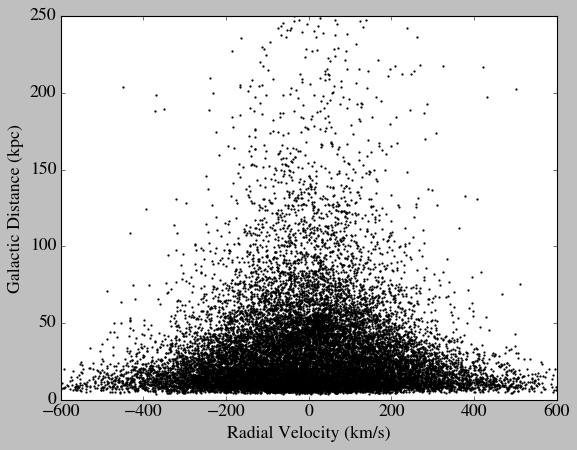

In [102]:
#plotting distance versus vrad (compared to Bullock 2005)

plt.scatter(rad_t.radial_velocity/u1.km*u1.s,testd['rad'],s=1,c='b')
plt.ylabel('Galactic Distance (kpc)')
plt.xlabel('Radial Velocity (km/s)')
plt.xlim(-600,600)
plt.ylim(0,250)
plt.show()
plt.show()

In [103]:
rad_t = get_coord_obj_rot_gsr(testd)
gc1 = rad_t.transform_to(coord.Galactocentric)
r2= np.sqrt(gc1.x**2+gc1.y**2+gc1.z**2)



# Function for calculating the space separation and the velocity difference in each shell



zmin = 20
zmax = 100
zlim = 4.

ra = r2/u1.kpc
r2= ra

vral = rad_t.radial_velocity/u1.km*u1.s
groupidi = range(0,len(testd))


# cutting r and z > 20 & r < 60 kpc stars
df1=pd.DataFrame()
df2=pd.DataFrame()
df3 = pd.DataFrame()
df1['x']=gc1.x[ (zmin < r2 ) & (r2 < zmax ) ]
df1['y']=gc1.y[ (zmin < r2 ) & (r2< zmax ) ]
df1['z']=gc1.z[ (zmin < r2 ) & (r2 < zmax ) ]
df1['Vgal']= vral[ (zmin <r2 ) & (r2 < zmax ) ]
df1['r']= r2[ (zmin < r2) & (r2 < zmax )]
df1['starid']= np.array(groupidi)[ (zmin < r2) & (r2 < zmax )]
df1['index']= np.arange(0,len(df1['r']),1)
#print (df1['index'])
df2['r']=df1['r'][(np.absolute(df1['z']) > zlim)]
df2['x']=df1['x'][(np.absolute(df1['z']) > zlim)]
df2['y']=df1['y'][(np.absolute(df1['z']) > zlim) ]
df2['z']=df1['z'][(np.absolute(df1['z']) > zlim)]
df2['Vgal']= df1['Vgal'][(np.absolute(df1['z']) > zlim)]
df2['starid']= df1['starid'][(np.absolute(df1['z']) > zlim)]
df2['index']= np.arange(0,len(df2['r']),1)


df3 = df2.sort_values(by=['index'])

#df3 = df3.sample(n = 10000)

#df3.to_csv("df3_10000_halo12_grav2.5.csv")

<SkyCoord (Galactic): (l, b, distance) in (deg, deg, kpc)
    [(297.17574845,   3.74217546,  6.52994255),
     (353.87742281,   0.69535052, 44.56630378),
     (195.98370488,  41.05297554, 82.3572988 ), ...,
     ( 12.32793558,  19.22404944, 65.04515475),
     (  5.7654848 ,  -4.70004263, 19.12947327),
     (338.95286726, -11.23261548, 19.62948615)]
 (pm_l_cosb, pm_b, radial_velocity) in (mas / yr, mas / yr, km / s)
    [(-0.10275147,  1.62052579, -149.9967723 ),
     ( 0.1303645 , -0.52252212,  194.05882375),
     ( 0.19305458,  0.10914248,  -49.17023278), ...,
     (-0.0172285 , -0.00940155, -315.03612326),
     ( 0.21654994,  1.4133183 , -218.14448399),
     (-0.07785748,  0.91219006, -101.00939673)]>


In [104]:
df3

r          x          y          z        Vgal  starid  index
1     88.559114 -67.828632 -17.101739  54.309520  -49.170233       2      0
3     38.251542  11.480025  34.074849 -13.049680 -237.772162       9      1
5     97.242792  85.150122 -46.591792  -5.901036   76.099738      14      2
6     78.342238 -30.747581  64.414029  32.294355 -129.056183      16      3
7     62.256439  57.876537  15.643671 -16.776360  -37.765514      18      4
8     21.598975 -15.428295  -4.111989  14.545617  355.277093      19      5
9     37.177319  36.163424  -2.531515   8.243253  194.142686      20      6
10    25.809490  22.612523   6.834741  10.396629 -233.649379      22      7
11    20.744658  14.950143  -6.198473 -12.977403 -130.884968      24      8
12    42.752999  12.867390 -39.385209  10.538242   43.753253      25      9
13    32.496011   4.443754   7.198456 -31.375564  -96.550944      27     10
14    39.651269  15.940667 -25.866629 -25.476180  -81.573978      33     11
15    39.485120  30.509551   0.879072 -25.049336 -119.869261      34     12
16    55.765149 -44.569392  -5.362873 -33.084147  -14.868472      36     13
17    37.131924  21.566911 -28.802447  -9.168813   20.671593      38     14
18    61.412798  23.270372 -16.526217  54.377437 -247.403736      39     15
19    33.826205  29.393948  -0.530486 -16.731005   37.470214      40     16
20    27.430544 -17.566770 -20.478534  -4.947020  236.003218      41     17
21    28.645767  -8.025715  27.201221   4.032548  268.559321      42     18
23    40.003027 -22.676985 -31.259247 -10.433407   24.411576      45     19
24    23.813738  -4.421771 -14.388277 -18.453171  -21.810031      47     20
25    22.426668 -13.152001   7.347523  16.613073  110.068707      51     21
26    67.278750 -34.679756 -41.920012  39.578496  -90.413097      54     22
27    37.982837   2.123656 -35.462396 -13.438916 -180.373917      59     23
28    28.324540 -26.530405  -6.886369  -7.141082  -53.030338      60     24
29    31.985901   1.400217  31.064765   7.491169 -236.534387      64     25
30    35.047963  30.424147 -12.271915 -12.334144   18.733510      66     26
31    63.154286  60.266617   8.841901  16.679912    9.325879      67     27
32    36.536833  -9.534566 -34.747373  -6.054113  200.402652      68     28
33    23.096043 -11.974189 -16.953275 -10.130769  171.179133      70     29
...         ...        ...        ...        ...         ...     ...    ...
9262  22.824280   3.424967  16.507733  15.385451   50.221924   19925   7674
9263  32.427700  -6.153249 -30.633001   8.678280 -103.723232   19927   7675
9264  39.802658  27.355820 -17.505398  23.010253 -184.300654   19928   7676
9265  54.123544  47.892647  20.709941 -14.378829  -47.670706   19929   7677
9267  46.554643  40.164066  17.070213 -16.210813 -214.245093   19932   7678
9268  23.475830  -5.339155  22.165962  -5.592686  -43.368876   19933   7679
9269  60.146522 -31.457725 -48.797540  15.710370  171.085497   19934   7680
9270  52.180818  17.299723  48.174087  10.139757 -110.243271   19937   7681
9271  44.904566 -37.334750 -21.851697 -12.043249   16.738573   19938   7682
9273  26.334666  -0.189304 -22.241766  14.099031  189.404685   19941   7683
9274  22.926638  -7.644553  17.020073 -13.323238 -348.685044   19945   7684
9275  56.512294  37.049868  29.935196 -30.411029   44.402787   19948   7685
9276  35.818557   8.628944 -21.811331  27.069840   83.077243   19950   7686
9277  34.623219 -29.036669  -9.440824 -16.325134  -68.152233   19951   7687
9279  21.281245   1.449609  19.579841  -8.210960  326.713907   19953   7688
9282  31.374456  11.023702  25.148598 -15.178357 -171.781186   19958   7689
9284  34.102996 -15.615975   6.139166  29.689499   34.945728   19966   7690
9285  31.433805   9.547105   3.717264 -29.717315  231.880993   19969   7691
9286  20.795048  16.338362   4.728031 -11.964015  122.433865   19970   7692
9287  25.493200  10.011635 -22.932685   4.874666 -160.091188   19972   7693
9288  27.010176  25.379383   5.092519  -7.713802  132.352773  

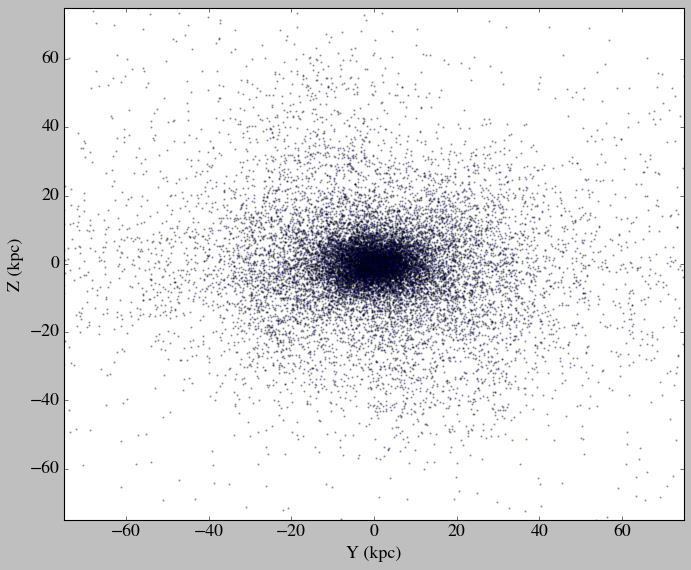

In [105]:
#plotting the x, y position for the selected 30000 sample
plt.figure(figsize=(10,8))
ax = plt.axes()
ax.scatter(gc1.y,gc1.z,s=1,alpha=0.3)
ax.set_xlabel('Y (kpc)')
ax.set_ylabel('Z (kpc)')
#ax.set_zlabel('Z (kpc)')
ax.set_ylim(-75,75)
ax.set_xlim(-75,75)
#ax.set_zlim(-75,75)
#plt.savefig('3d.png')
plt.show()

# Velocity dispersion

In [121]:
class Comp:
    def __init__(self, x, y, z, rv, groupid):
        '''
        class for the input of the correlation function
        :param x: x position for the target
        :param y: y position for the target
        :param z: z position for the target
        :param rv: radial velocity for the target

        '''

        self.x = np.array(x)
        self.y = np.array(y)
        self.z = np.array(z)
        self.rv = np.array(rv)
        self.groupid = np.array(groupid)


def v_diff(spaces, data, interval, times):
    '''
        :param spaces: Scale for space sparation
        :param data: The orginal dataset
        :param interval: raidal space interval for the shell of calculating the space separation


    '''

    vdiffhf = []
    rlim = []
    num = []
    spectf = []
    indexoutf = []

    zmini = [20, 26, 32, 38, 44, 60, 76]
    zmaxi = [26, 32, 38, 44, 60, 76, 92]
    for ii in range(0, 7, 1):

        rlim.append(zmini[ii])
        zmin = zmini[ii]
        zmax = zmaxi[ii]
        dfx = pd.DataFrame()
        dfxf = pd.DataFrame()
        dfx['x'] = data['x'][(zmin < data['r']) & (data['r'] < zmax)]
        # print (dfx['x'])
        dfx['y'] = data['y'][(zmin < data['r']) & (data['r'] < zmax)]
        dfx['z'] = data['z'][(zmin < data['r']) & (data['r'] < zmax)]
        dfx['Vgal'] = data['Vgal'][(zmin < data['r']) & (data['r'] < zmax)]
        dfx['index'] = data['index'][(zmin < data['r']) & (data['r'] < zmax)]

        dfx['r'] = data['r'][(zmin < data['r']) & (data['r'] < zmax)]
        # zmin=zmax
        indexf = []
        vdiff = []
        spacei = []
        num.append(len(dfx['r']))
        print(len(dfx))
        for kk in range(0, len(dfx), times):
            minn = kk
            maxx = kk + times
            # print (minn,maxx)

            v, i, s = pair_cal(data, dfx[minn:maxx], spaces)
            # print (len(dfx))

            indexf.append(i)
            vdiff.append(v)
            spacei.append(s)
            # print (v)
        # print (vdiff)
        vdiffhf.append(np.concatenate((vdiff)))
        # print (vdiffhf)
        spectf.append(np.concatenate(spacei))
        indexoutf.append(np.concatenate(indexf))

    return rlim, vdiffhf, num, spectf, indexoutf


def pair_cal(dfall, df, spaces):
    dfx2 = df.sort_values(by=['index'])

    indexp = [x for x in dfall.index if x not in dfx2.index]
    indexs = np.append(np.array(dfx2.index), np.array(indexp))

    dfxf = dfall.loc[indexs]

    k = Comp(dfx2['x'], dfx2['y'], dfx2['z'], dfx2['Vgal'], dfx2['index'])
    k2 = Comp(dfxf['x'], dfxf['y'], dfxf['z'], dfxf['Vgal'], dfxf['index'])

    # print (k.rv,k2.rv)


    indexf = []
    vdiff = []
    spacedt = []

    # calculating the velocity difference and space separation for each shell
    for jj in range(0, len(k.rv)):

        # print (k.rv,k2.rv)


        vi = np.repeat(k.rv[jj], len(k2.rv))
        xi = np.repeat(k.x[jj], len(k2.rv))
        yi = np.repeat(k.y[jj], len(k2.rv))
        zi = np.repeat(k.z[jj], len(k2.rv))

        diffv = (vi - k2.rv) ** 2
        diffx = (xi - k2.x) ** 2
        diffy = (yi - k2.y) ** 2
        diffz = (zi - k2.z) ** 2
        indext = []
        for kk in range(0, len(k2.groupid)):
            indext.append(str(k.groupid[jj]) + '-' + str(k2.groupid[kk]))

            # diff = diffv+diffx+diffy+diffz
        spaced = diffx + diffy + diffz

        indexf.append(indext)
        # dia.append(diff)
        vdiff.append(vi - k2.rv)
        spacedt.append(np.sqrt(spaced))
        # diaf = np.array(dia)[np.triu_indices(len(dfx['r']),1)]
    vdiffto = np.array(vdiff)[np.triu_indices(len(k.rv), 1)]
    specdto = np.array(spacedt)[np.triu_indices(len(k.rv), 1)]
    indexfo = np.array(indexf)[np.triu_indices(len(k.rv), 1)]
    # spect.append(specdto)
    # indexout.append(indexfo[specdto < spaces])

    # print (len(vdiffto),len(specdto))

    # vdiffh.append(vdiffto[specdto < spaces])

    # print (len(vdiff))
    return vdiffto[specdto < spaces], indexfo[specdto < spaces], specdto


In [107]:
rlimf = []
test1f = []
numf = []
sepf = []
indexf = []

for scale in [0.5,2,6,12]:
    rlim, test1, num, sep, indexii = v_diff(scale, df3, 10,500)
    rlimf.append(rlim)
    test1f.append(test1)
    numf.append(num)
    sepf.append(sep)
    indexf.append(indexii)


1371
1221
1163
969
1654
772
411
1371
1221
1163
969
1654
772
411
1371
1221
1163
969
1654
772
411
1371
1221
1163
969
1654
772
411


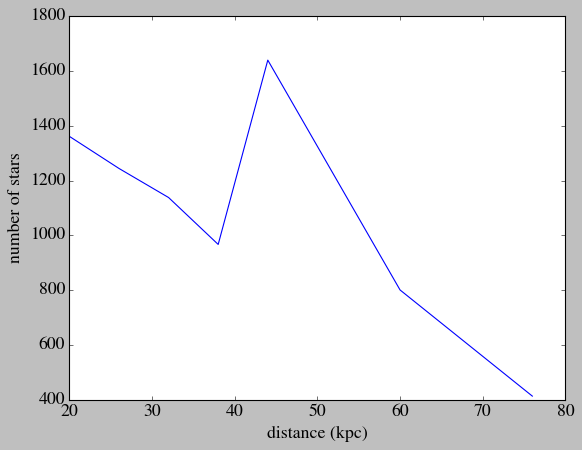

In [26]:

plt.plot(rlimf[0],num,c='b')
plt.ylabel('number of stars')
plt.xlabel('distance (kpc)')

plt.show()

In [157]:
def boopstrap_sat(veldiff,fracnumber,times,bins):
    booptoth = []
    booptotb = []
    for kk in range(0, len(veldiff)):
        
        totalindex = range(0, len(veldiff[kk]))
        s6h=[]
        s6b= []
    #generate the total bootstrap spectra (250) for 10000 times
        number = int(len(veldiff[kk])*0.9)
        bootstrapindex = sorted(choices(totalindex, k=number) for i in range(times))
        #print (bootstrapindex)
        for ii in range(0, len(bootstrapindex)):
            
            vel = veldiff[kk][bootstrapindex[ii]]
        
            hist, bin_edges = np.histogram(vel[(vel < 1000)  & (vel > -1000)], density=False,bins=bins)
            s6h.append(hist)
            s6b.append(bin_edges)
        booptoth.append(s6h)
        booptotb.append(s6b)
    return booptoth,booptotb





In [158]:
testboop = boopstrap_sat(test1f[3],0.9,1000,100)

In [159]:
len(testboop[0][2])

1000

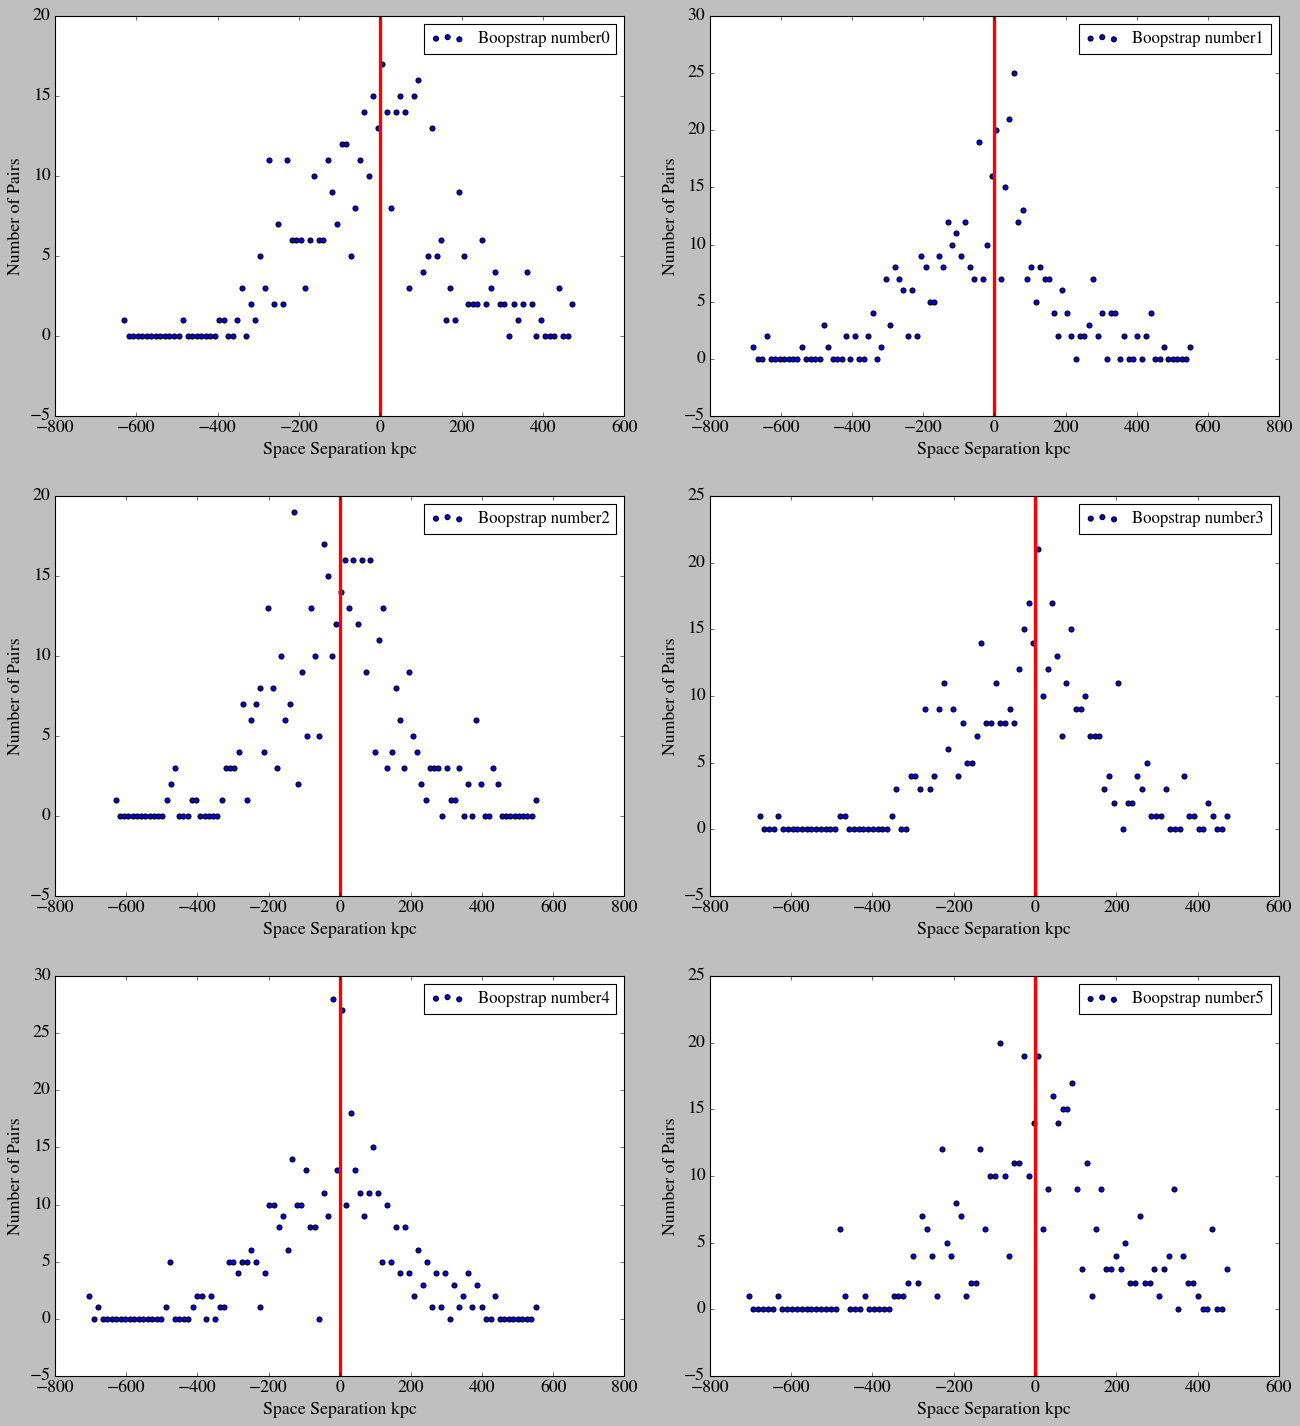

In [160]:
fig, ax = plt.subplots(3, 2, figsize=(18, 20), gridspec_kw={'wspace': 0.15, 'hspace': 0.2}, sharex=False, sharey=False)

fig.subplots_adjust(left=0.05, bottom=0.05, right=0.9, top=0.9)
k = 0
    
degrees = [(0, 0), (1, 0), (2, 0), (3, 0), (0, 1), (1, 1), (2, 1), (0, 2), (1, 2), (0, 3)]
for index in range(ax.shape[0]):
    for jndex in range(ax.shape[1]):
        ax[index][jndex].scatter(testboop[1][6][k][:100],testboop[0][6][k],  label='Boopstrap number'+str(k))
            
        ax[index][jndex].axvline(0,linewidth = 3,c= 'r')
        ax[index][jndex].set_xlabel('Space Separation kpc')
        ax[index][jndex].set_ylabel('Number of Pairs')
        ax[index][jndex].legend(loc=1, prop={'size': 15})
        
            
            
        k = k + 1
#plt.savefig('halo09_space_bound.png')            
plt.show()

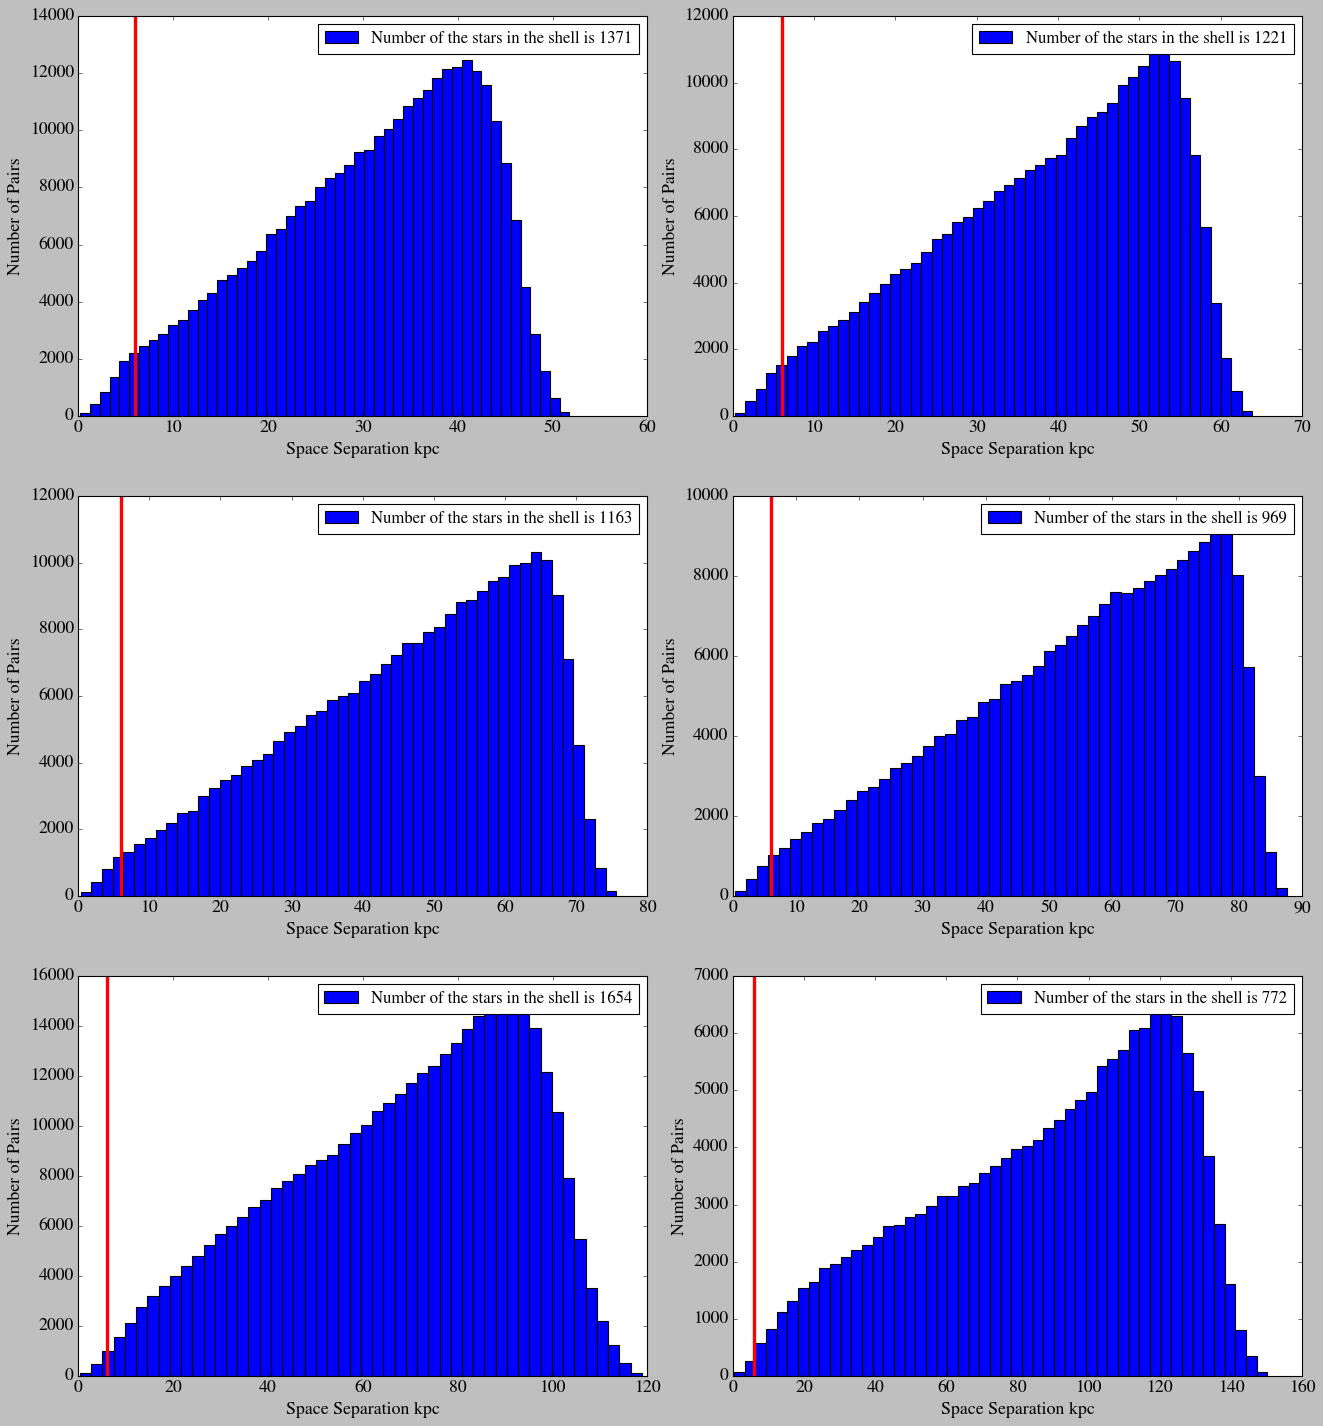

In [161]:
fig, ax = plt.subplots(3, 2, figsize=(18, 20), gridspec_kw={'wspace': 0.15, 'hspace': 0.2}, sharex=False, sharey=False)

fig.subplots_adjust(left=0.05, bottom=0.05, right=0.9, top=0.9)
k = 0
    
degrees = [(0, 0), (1, 0), (2, 0), (3, 0), (0, 1), (1, 1), (2, 1), (0, 2), (1, 2), (0, 3)]
for index in range(ax.shape[0]):
    for jndex in range(ax.shape[1]):
        ax[index][jndex].hist(sep[k], bins=50, label='Number of the stars in the shell is '+str(num[k]))
            
        ax[index][jndex].axvline(6,linewidth = 3,c= 'r')
        ax[index][jndex].set_xlabel('Space Separation kpc')
        ax[index][jndex].set_ylabel('Number of Pairs')
        ax[index][jndex].legend(loc=1, prop={'size': 15})
        
            
            
        k = k + 1
plt.savefig('halo09_space_bound.png')            
plt.show()

In [162]:
zmini = [20, 26, 32, 38, 44, 60, 76]
zmaxi = [26, 32, 38, 44, 60, 76, 92]

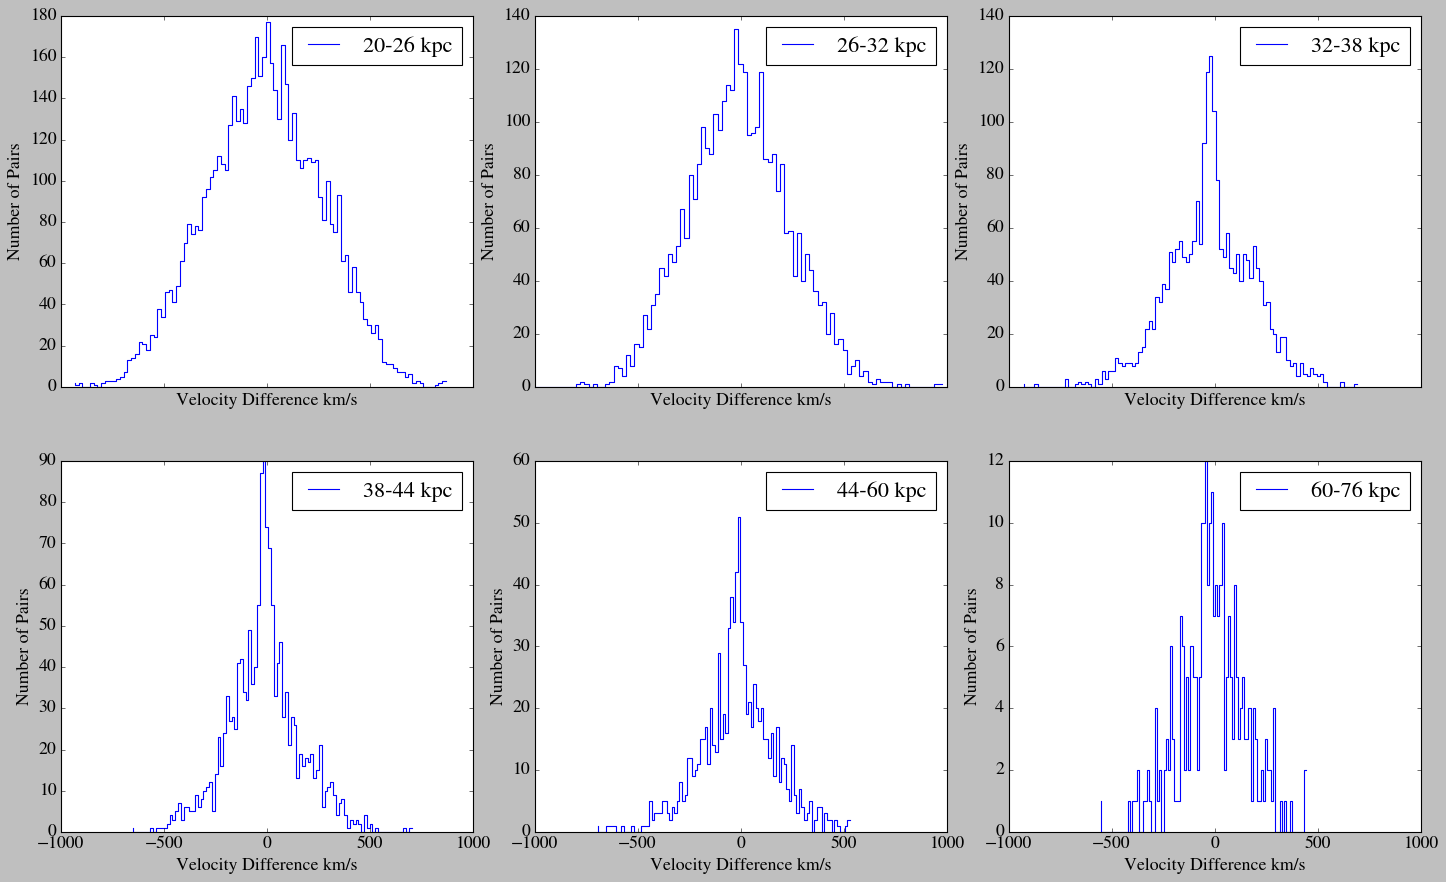

In [163]:
fig, ax = plt.subplots(2, 3, figsize=(20, 12), gridspec_kw={'wspace': 0.15, 'hspace': 0.2}, sharex=True, sharey=False)

fig.subplots_adjust(left=0.05, bottom=0.05, right=0.9, top=0.9)
k = 0
sc = 2
degrees = [(0, 0), (1, 0), (2, 0), (3, 0), (0, 1), (1, 1), (2, 1), (0, 2), (1, 2), (0, 3)]
for index in range(ax.shape[0]):
    for jndex in range(ax.shape[1]):
        datay, datax = np.histogram(test1f[sc][k], density=False,bins=100)
        ax[index][jndex].step(datax[:100],datay, label=str(int(zmini[k])) +'-'+ str(int(zmaxi[k]))+' kpc')
            
        ax[index][jndex].set_xlim(-1000,1000)
        ax[index][jndex].set_xlabel('Velocity Difference km/s')
        ax[index][jndex].set_ylabel('Number of Pairs')
        ax[index][jndex].legend( prop={'size': 20})
        
            
            
        k = k + 1
plt.savefig('halo17_space_2_unbound.png')             
plt.show()

In [164]:
def one_gaussian(params,x,ydata):
    h1 = params[0]
    c1 = params[1]
    w1 = params[2]
    offset = params[3]
    
    #x,ydata = s6b[num][:100],s6h[num]
    ypred = gaussian(x, h1, c1, w1, offset) 
      
    LL = -np.sum(stats.poisson.logpmf(ydata, ypred))
    #LL = 0
    #for ii in range(0,len(ydata)):
        #print (math.factorial(ydata[ii]))
        #print (np.log(math.factorial(ydata[ii])))
        #print (math.factorial(ydata[ii]),ypred[ii],np.log(ypred[ii]))
        #LL = LL+np.log(np.asarray(math.factorial(ydata[ii])))+ypred[ii]-ydata[ii]*np.log(ypred[ii])
    return LL 



In [165]:
def two_gaussians(params,x,ydata):
    h1 = params[0]
    c1 = params[1]
    w1 = params[2]
    h2 = params[3]
    c2 =params[4]
    w2 =params[5]
    offset = params[6]
    sd = params[7]
    #x,ydata = s6b[num][:100],s6h[num]
    ypred = (gaussian(x, h1, c1, w1, offset=0) +
        gaussian(x, h2, c2, w2, offset=0)  + 
        offset)
    #LL = -np.sum(stats.norm.logpdf(ydata, loc=ypred, scale=sd) )
    LL = -np.sum(stats.poisson.logpmf(ydata, ypred))
    #LL = 0
    #for ii in range(0,len(ydata)):
        #print (math.factorial(ydata[ii]))
        #print (np.log(math.factorial(ydata[ii])))
        #print (math.factorial(ydata[ii]),ypred[ii],np.log(ypred[ii]))
        #LL = LL+np.log(np.asarray(math.factorial(ydata[ii])))+ypred[ii]-ydata[ii]*np.log(ypred[ii])
    return LL 
def gaussian(x, height, center, width, offset):
    return height*np.exp(-(x - center)**2/(2*width**2)) + offset

In [181]:
def fitting_result(x,y,h1,c1, w1, h2, c2, w2,offset,sd,bins,k):
    
   

    guess6= [h1,c1, w1, h2, c2, w2,offset,sd]
    #LL = -np.sum(stats.norm.logpdf(ydata, loc=yPred, scale=sd) )
    bds1=((0, 9999), (-1000,1000), (0,50), (0,9999), (-1000,1000),(50,9999),(-9999,9999),(-9999,9999))
    optim1 = minimize(two_gaussians, guess6,args=(x,y),method = 'Nelder-Mead',bounds = bds1)
    optim2 = minimize(one_gaussian, [h1,c1, w1,offset,sd],method = 'Nelder-Mead',args=(x,y))
   
    #np.sum(((y-two_gaussians(x, *optim1))**2)/(poisson.std(50,loc=0)**2))/(bins-len(guess6))
    
    #chisq1 = chisquare(y,two_gaussians(x, *optim1))[0]
    #print (optim1.x)
    p1 = optim1.x
    optim1=p1
    ypred = (gaussian(x, p1[0], p1[1], p1[2], offset=0) +
        gaussian(x, p1[3], p1[4], p1[5], offset=0)  + 
        p1[6])
    LL1  = -np.sum(stats.poisson.logpmf(y, ypred))
    #chisq1 =  
    #print ('err',np.sqrt(np.diag(success1)))
    
   
    #np.sum(np.absolute((two_gaussians(x, *optim1) - y)**2/two_gaussians(x, *optim1)))
    #chisq2 = np.sum(((y-one_gaussian(x, *optim2))**2)/(poisson.std(1/2*np.max(y),loc=0)**2))/(bins-len(guess6))
    p2 = optim2.x
    #print (optim2.x)
    ypred2 = gaussian(x, p2[0], p2[1], p2[2],p2[3])
    LL2  = -np.sum(stats.poisson.logpmf(y, ypred2))
    optim2 =p2
    #atio = np.exp(7-4)*np.exp(LL1/LL2)
    aic1 = 2*LL1+14
    aic2 = 2*LL2+8
    bic1 = -2*np.log(LL1)+7*np.log(bins)
    bic2 = -2*np.log(LL2)+4*np.log(bins)
    #print (aic1,aic2)
    
    interen = integrate.quad(lambda x: two_gaussians_ra(x, *optim1[:7]), -np.absolute((optim1[2]*3))+optim1[1],np.absolute(optim1[2]*3)+optim1[1])[0]
    intereb = integrate.quad(lambda x: two_gaussians_ra(x, *optim1[:7]), -np.absolute((optim1[5]*3))+optim1[4], -np.absolute((optim1[2]*3))+optim1[1])[0]
    ratio = interen/(2*intereb)
        
    #if (p1[0] > 0) & (p1[2] > 0) & (p2[0] > 0):
        #print ('two gaussian')
    #else:
        #print ('one gaussian')
    #print (str(k)+'&'+str(np.round(aic1,2))+'&'+str(np.round(aic2,2))+'&'+str(np.round(bic1,2))+'&'+str(np.round(bic2,2))+'\\')
    #print ('err',np.sqrt(np.diag(success2)))
    #plt.scatter(x,y, c='pink', label='measurement', marker='.', edgecolors=None)
    #plt.plot(x, ypred, c='b', label='fit of 2 Gaussians')
    #plt.title("Two Gaussian Fitting")
    #plt.ylabel("Number of pairs")
    #plt.xlabel("Velocity Difference")
    #plt.legend(loc='upper left')
    #plt.savefig('halo09_2_2gaussian_fit'+str(k)+'nocut.png')
    #plt.show()
    #plt.scatter(x,y, c='pink', label='measurement', marker='.', edgecolors=None)
    #plt.plot(x, (gaussian(x, p2[0], p2[1], p2[2], p2[3])), c='b', label='fit of 1 Gaussians')
    #plt.title("One gaussian fitting")
    #plt.xlabel("Velocity Difference")
    #plt.legend(loc='upper left')
    #plt.savefig('halo09_2_1gaussian_fit'+str(k)+'nocut.png')
    #plt.show()
    
    #return 
    #np.sum(np.absolute((one_gaussian(x, *optim2) - y)**2/one_gaussian(x, *optim2)))
    #if np.absolute(aic1)-np.absolute(aic2) < 0:
        #return LL1,p1
    #else:
        #return LL2,p2
         
    #if np.absolute(chisq1) < np.absolute(chisq2):
        
        #interen = integrate.quad(lambda x: two_gaussians(x, *optim1), -np.absolute((optim1[2]*3))+optim1[1],np.absolute(optim1[2]*3)+optim1[1])[0]
        #intereb = integrate.quad(lambda x: two_gaussians(x, *optim1), -np.absolute((optim1[5]*3))+optim1[4], -np.absolute((optim1[2]*3))+optim1[1])[0]
        #ratio = interen/(2*intereb)
        
        #print ('test',interen,intereb,-optim1[2]*3+optim1[1], optim1[2]*3+optim1[1],-optim1[5]*3+optim1[4], -optim1[2]*3+optim1[1],ratio)
    
        #return optim1,chisq1,success1,ratio
    #else:
        #print (chisq2)
    return optim1,optim2,aic1,aic2,ratio

In [189]:
def two_gaussians_ra(x, h1, c1, w1, h2, c2, w2, offset):
    return (gaussian(x, h1, c1, w1, offset=0) +
        gaussian(x, h2, c2, w2, offset=0)  + 
        offset)

In [190]:
def fitting_final(data,ap1,c1, width1, ap2, c2, width2,offset,bins):
    optim = []
    integrer = []
    fn = open("halo09_file2_12kpc.txt", "w")
    fn2 =  open("halo09_file1_12kpc.txt", "w")
    for ii in range(0,len(data)):
        datay, datax = np.histogram(data[ii][( data[ii]< 1000)  & (data[ii] > -1000)], density=False,bins=bins)
        optim1,optim2,aic1,aic2,ratio = fitting_result(datax[:100],datay,ap1,c1, width1, ap2,c2, width2,offset,0,bins,ii)
        #optim.append(np.append(result,chisq))  
        
        
        #optim1,optim2,aic1,aic2,ratio = fitting_result(data[data.keys()[ii+1]][(data[data.keys()[ii+1]] > -1000) &( data[data.keys()[ii+1]] < 1000)],data[data.keys()[ii]][(data[data.keys()[ii+1]] > -1000) &( data[data.keys()[ii+1]] < 1000)],ap1,c1, width1, ap2,c2, width2,offset,0,bins,ii)
        #optim.append(np.append(result,chisq))
       # print (result)
        #if len(result) > 5:
        fn.write('& ' + str(np.round(aic1,2)) + '& ' +str(np.round(optim1[0],2))+'& '+str(np.round(optim1[1],2))+ '& '+str(np.round(optim1[2],2))+'& '+str(np.round(optim1[3],2)) + '& '
               +str(np.round(optim1[4],2))+'& '+str(np.round(optim1[5],2))+'&  '+str(np.round(ratio,2))+ "\\"+'\n')
        fn2.write('& ' + str(np.round(aic2,2)) + '& ' +str(np.round(optim2[0],2))+'& '+str(np.round(optim2[1],2))+ '& '+str(np.round(optim2[2],2))+ '&  '+str(np.round(ratio,2))
               + "\\"+'\n')
        #print (ratio)
    fn.close()
    fn2.close()
    return optim1,optim2,aic1,aic2,ratio



In [194]:
def fitting_final_boot(datax,datay,ap1,c1, width1, ap2, c2, width2,offset,bins):
    optim1f = []
    optim2f = []
    aic1f = []
    aic2f = []
    #f = open("halo17_file2_100000.txt", "a")
    for ii in range(0,int(len(datax)),1):
        
        
        
        optim1,optim2,aic1,aic2,ratio = fitting_result(datax[ii][:100],datay[ii],ap1,c1, width1, ap2,c2, width2,offset,0,bins,ii)
        optim1f.append(optim1)
        optim2f.append(optim2)
        aic1f.append(aic1)
        aic2f.append(aic2)
        #optim.append(np.append(result,chisq))
       # print (result)
        #if len(result) > 5:
            #f.write('& ' + str(np.round(chisq,2)) + '& ' +str(np.round(result[2],2))+'$\pm$'+str(np.round(np.sqrt(np.diag(success1))[2],2))+ '& '+str(np.round(result[5],2))+'$\pm$'+str(np.round(np.sqrt(np.diag(success1))[5],2)) + '& '
               #+str(np.round(result[0],2))+'$\pm$'+str(np.round(np.sqrt(np.diag(success1))[0],2)) + '& '+str(np.round(result[3],2))+'$\pm$'+str(np.round(np.sqrt(np.diag(success1))[3],2)) + '& '+str(np.round(result[1],2))+'$\pm$'+str(np.round(np.sqrt(np.diag(success1))[1],2)) + '& '
               #+str(np.round(result[4],2))+'$\pm$'+str(np.round(np.sqrt(np.diag(success1))[4],2)) + '& '+str(np.round(ratio,2))+ "\\"+'\n')
        
        #print (ratio)
    #f.close()
    return optim1f,optim2f,aic1f,aic2f

In [192]:
optim1f,optim2f,aic1f,aic2f,ratio = fitting_final(test1f[3],5000,0, 30, 300,0, 200,0,100)

In [198]:
testboopaic1 = []
testboopaic2 = []
for ii in range(0,len(testboop[1])):
    
    optim1f,optim2f,aic1f,aic2f = fitting_final_boot(testboop[1][ii],testboop[0][ii],5000,0, 30, 300,0, 200,0,100)
    testboopaic1.append(aic1f)
    testboopaic2.append(aic2f)





In [199]:
for k in range(0,len(testboopaic1)):
    
    #for jj in range(0,len(testboopaic1[k])):
    a = testboopaic1
    print (st.t.interval(0.95, len(a[k])-1, loc=np.mean(a[k]), scale=st.sem(a[k])))
    

(892.2055181660295, 897.0143374352091)
(749.7143599321718, 752.9763839881472)
(699.6762119739432, 703.0597456518111)
(678.9229267962897, 682.1256588135899)
(623.8604562269587, 627.0372906190415)
(557.0057436820272, 560.4986834368134)
(413.58795065966325, 416.52967145330587)


In [200]:
zmini = [20, 26, 32, 38, 44, 60, 76]
zmaxi = [26, 32, 38, 44, 60, 76, 92]

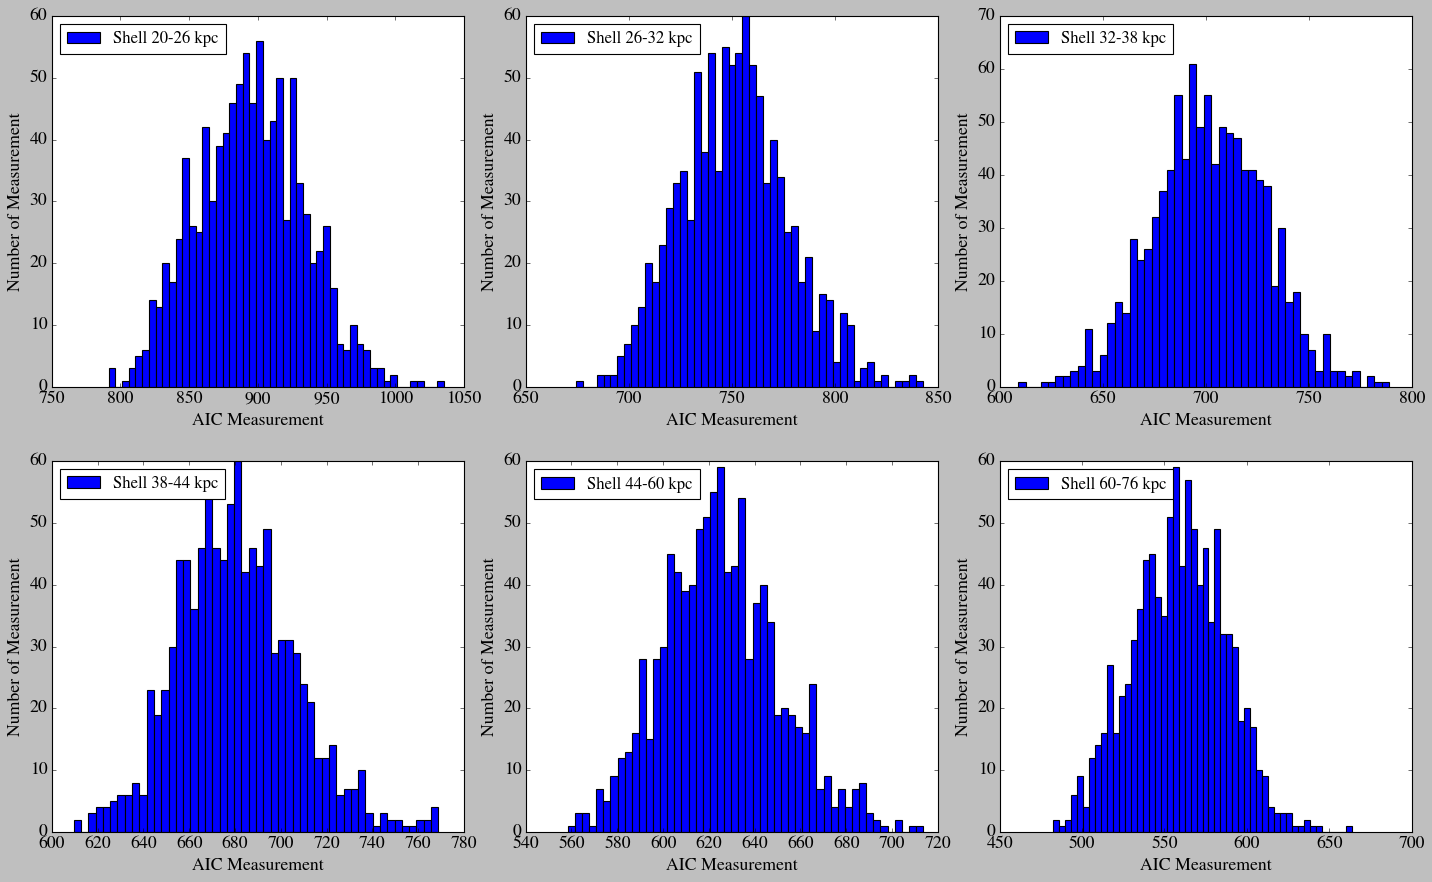

In [201]:
fig, ax = plt.subplots(2, 3, figsize=(20, 12), gridspec_kw={'wspace': 0.15, 'hspace': 0.2}, sharex=False, sharey=False)

fig.subplots_adjust(left=0.05, bottom=0.05, right=0.9, top=0.9)
k = 0
sc = 0
degrees = [(0, 0), (1, 0), (2, 0), (3, 0), (0, 1), (1, 1), (2, 1), (0, 2), (1, 2), (0, 3)]
for index in range(ax.shape[0]):
    for jndex in range(ax.shape[1]):
        ax[index][jndex].hist(testboopaic1[k],bins=50, label='Shell '+str(int(zmini[k])) +'-'+ str(int(zmaxi[k]))+' kpc')
            
        #ax[index][jndex].set_xlim(-1000,-200)
        ax[index][jndex].set_xlabel('AIC Measurement')
        ax[index][jndex].set_ylabel('Number of Measurement')
        ax[index][jndex].legend(loc=2, prop={'size': 15})
        
            
            
        k = k + 1
#plt.savefig('halo17_space_6_test.png')             
plt.show()

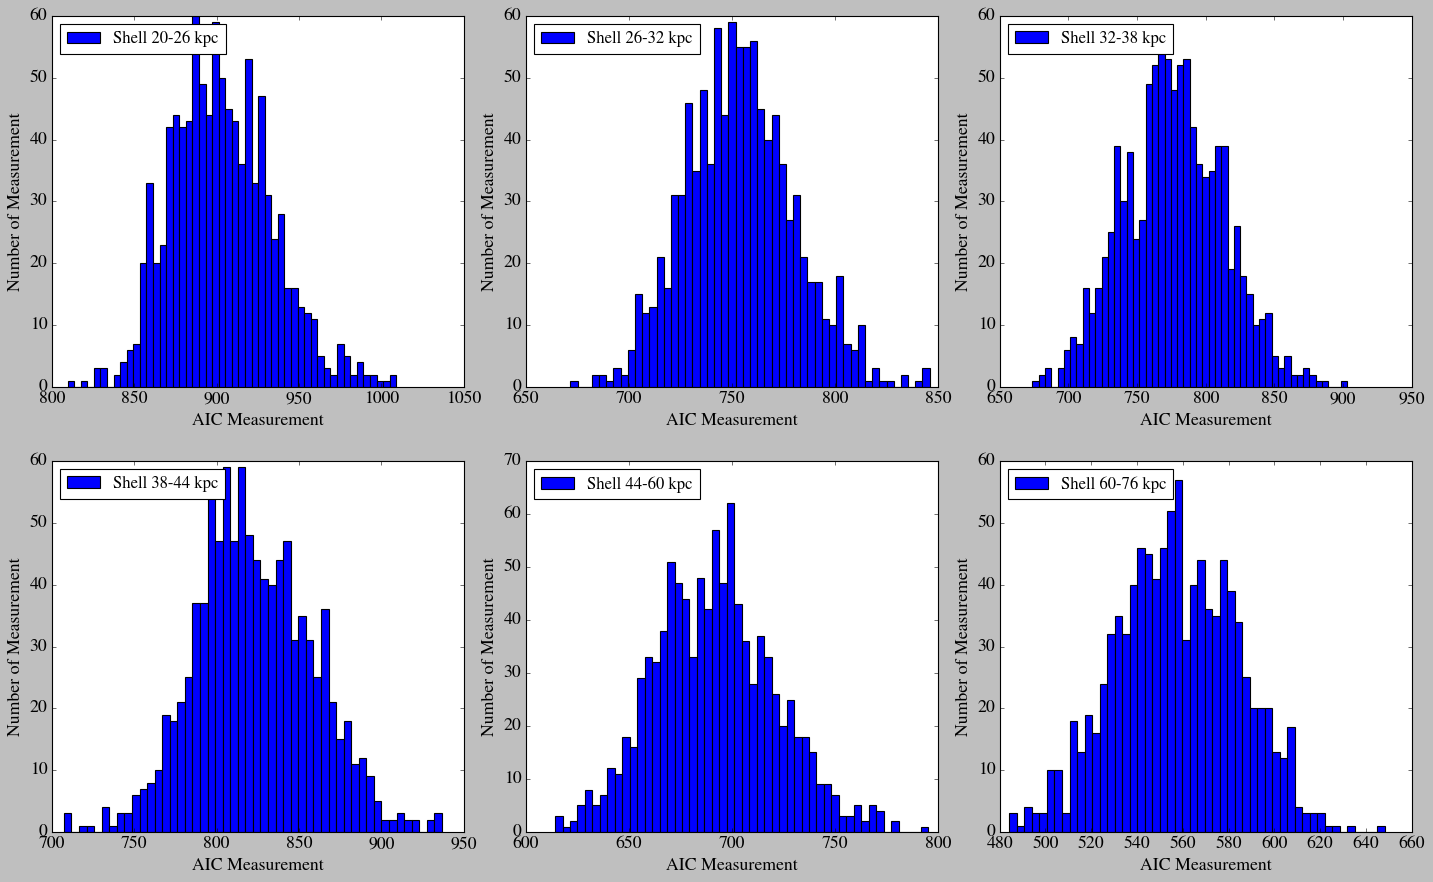

In [202]:
fig, ax = plt.subplots(2, 3, figsize=(20, 12), gridspec_kw={'wspace': 0.15, 'hspace': 0.2}, sharex=False, sharey=False)

fig.subplots_adjust(left=0.05, bottom=0.05, right=0.9, top=0.9)
k = 0
sc = 0
degrees = [(0, 0), (1, 0), (2, 0), (3, 0), (0, 1), (1, 1), (2, 1), (0, 2), (1, 2), (0, 3)]
for index in range(ax.shape[0]):
    for jndex in range(ax.shape[1]):
        ax[index][jndex].hist(testboopaic2[k],bins=50, label='Shell '+str(int(zmini[k])) +'-'+ str(int(zmaxi[k]))+' kpc')
            
        #ax[index][jndex].set_xlim(-1000,-200)
        ax[index][jndex].set_xlabel('AIC Measurement')
        ax[index][jndex].set_ylabel('Number of Measurement')
        ax[index][jndex].legend(loc=2, prop={'size': 15})
        
            
            
        k = k + 1
#plt.savefig('halo17_space_6_test.png')             
plt.show()

In [ ]:
plt.hist(testboopaic[3],bins=50)
plt.xlabel('Aic Measurement')
plt.ylabel('Number')
plt.show()

#### plt.hist(testboopaic[2],bins=50)
plt.xlabel('Aic Measurement')
plt.ylabel('Number')
plt.show()

In [ ]:
def gaussian_likelihood(leng):
    lowbu = []
    highbu = [] 
    lowbu2=[]
    highbu2= [] 
    for num in range(0,leng):
        guess6= [np.max(s6h[num]),0, 60, np.max(s6h[num])/2 , 0, 120,0,100] 
        x,ydata = s6b[num][:100],s6h[num]
    #LL = -np.sum(stats.norm.logpdf(ydata, loc=yPred, scale=sd) )
        optim1 = minimize(two_gaussians, guess6, method='Nelder-Mead',args=(x,ydata))
        p1 = optim1.x

        ypred = (gaussian(s6b[num][:100], p1[0], p1[1], p1[2], offset=0) +
            gaussian(s6b[num][:100], p1[3], p1[4], p1[5], offset=0)  + p1[6])

        LL = -np.sum(stats.poisson.logpmf(s6h[num], ypred))

        plt.scatter(s6b[num][:100],s6h[num], c='pink', label='measurement', marker='.', edgecolors=None)
        plt.plot(s6b[num][:100],(gaussian(s6b[num][:100], p1[0], p1[1], p1[2], offset=0) +gaussian(s6b[num][:100], p1[3], p1[4], p1[5], offset=0)  + 
        p1[6]), c='b', label='fit of 2 Gaussians')
        plt.title("Two gaussian fitting")
        plt.ylabel("Number of pairs")
        plt.xlabel("Velocity Difference")
        plt.legend(loc='upper left')
#plt.plot(np.array(xnum)[lowi:highi+1], np.array(newdiff)[lowi:highi+1],c='r')
#plt.plot(np.array(xnum2)[highi2:lowi2+1],np.array(newdiff2)[highi2:lowi2+1],c='r')
#plt.savefig('result.png')
        plt.show()
    
        diff = s6h[num]-(gaussian(s6b[num][:100], p1[0], p1[1], p1[2], offset=0) +
        gaussian(s6b[num][:100], p1[3], p1[4], p1[5], offset=0)  + 
        p1[6])
        width = p1[2]

#for ii in range(0,len(diff)):


        newdiff = diff[np.where(s6b[num][:100] > 3*width)]
        newdiff2 = diff[np.where(s6b[num][:100] < -3*width)]
        xnum = s6b[num][:100][np.where(s6b[num][:100] > 3*width)]
        xnum2 = s6b[num][:100][np.where(s6b[num][:100] <  -3*width)]
        lowi = np.array(range(0,100))[np.where(newdiff == np.min(newdiff))][0]
        highi = np.array(range(0,100))[np.where(newdiff == np.max(newdiff))][0]
        lowi2 = np.array(range(0,100))[np.where(newdiff2 == np.min(newdiff2))][0]
        highi2 = np.array(range(0,100))[np.where(newdiff2 == np.max(newdiff2))][0]


       # finaladd = np.append(np.array(newdiff2)[lowi2:highi2],np.array(newdiff)[lowi:highi])
        xnumf = np.append(np.array(xnum2)[lowi2:highi2],np.array(xnum)[lowi:highi])
#plt.plot(np.array(xnum2)[highi2:lowi2+1],np.array(newdiff2)[highi2:lowi2+1])
        plt.scatter(s6b[num][:100],s6h[num], c='pink', label='measurement', marker='.', edgecolors=None)
        plt.plot(s6b[num][:100],s6h[num]-(gaussian(s6b[num][:100], p1[0], p1[1], p1[2], offset=0) +
        gaussian(s6b[num][:100], p1[3], p1[4], p1[5], offset=0)  + 
        p1[6]), c='b', label='fit of gaussian Gaussians')
        plt.title("Two gaussian fitting")
        plt.ylabel("Number of pairs")
        plt.xlabel("Velocity Difference")
        plt.legend(loc='upper left')
        if (lowi < highi+1) &  (highi2 < lowi2+1) :
            plt.plot(np.array(xnum)[lowi:highi+1], np.array(newdiff)[lowi:highi+1],c='r')
            plt.plot(np.array(xnum2)[highi2:lowi2+1],np.array(newdiff2)[highi2:lowi2+1],c='r')
        else:
            
            lowb = lowi
            lowa = highi
            lowi = lowa
            highi = lowb
            
            lowb2 = lowi2
            lowa2 =highi2
            lowi2 = lowa2
            highi2 = lowb2
            plt.plot(np.array(xnum)[lowi:highi+1], np.array(newdiff)[lowi:highi+1],c='r')
            plt.plot(np.array(xnum2)[highi2:lowi2+1],np.array(newdiff2)[highi2:lowi2+1],c='r')
            
            
        print (lowi,highi+1,highi2,lowi2+1)
        plt.show()                        

        lowbu.append(xnum2[highi2])
        lowbu2.append(xnum2[lowi2])
        highbu.append(xnum[lowi])
        highbu2.append(xnum[highi])
        
    return lowbu,lowbu2,highbu,highbu2

    

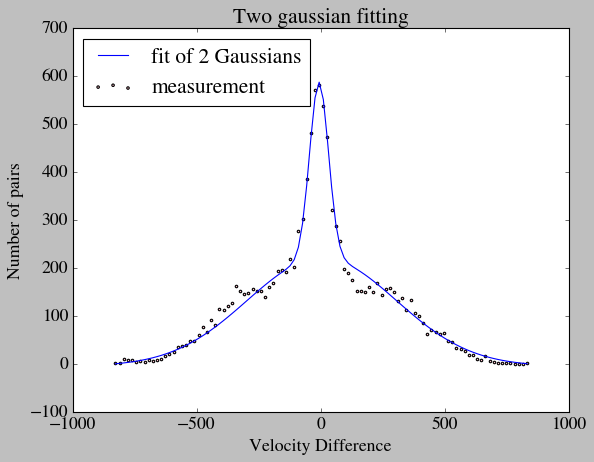

1 15 29 37


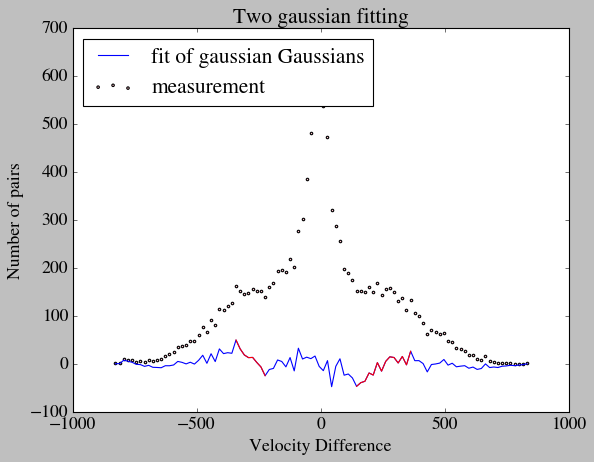

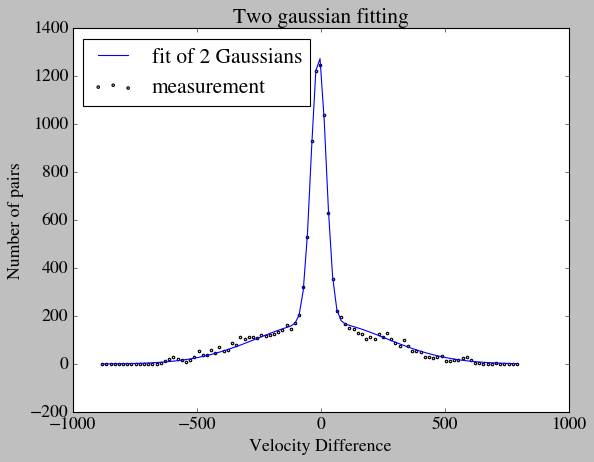

5 11 33 46


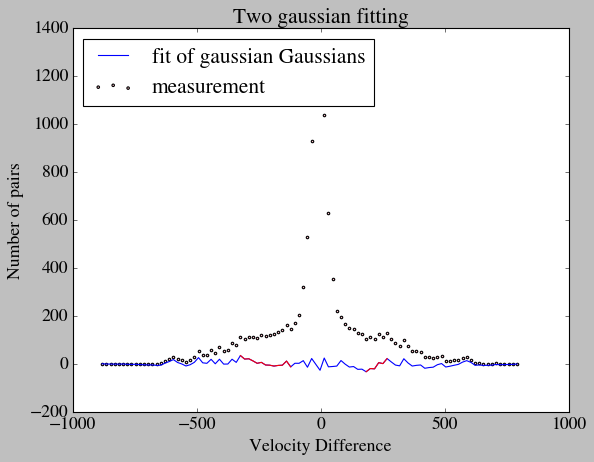

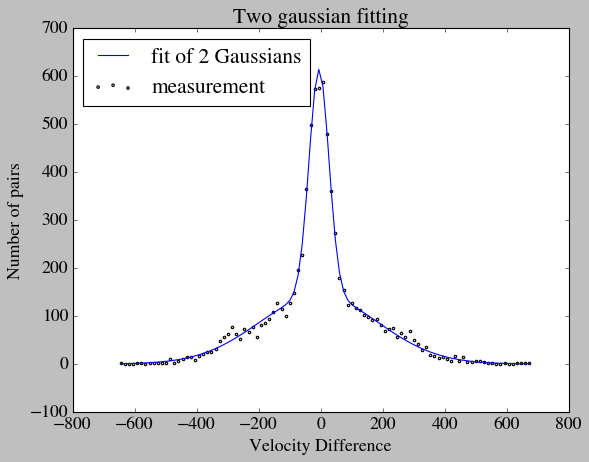

8 15 27 34


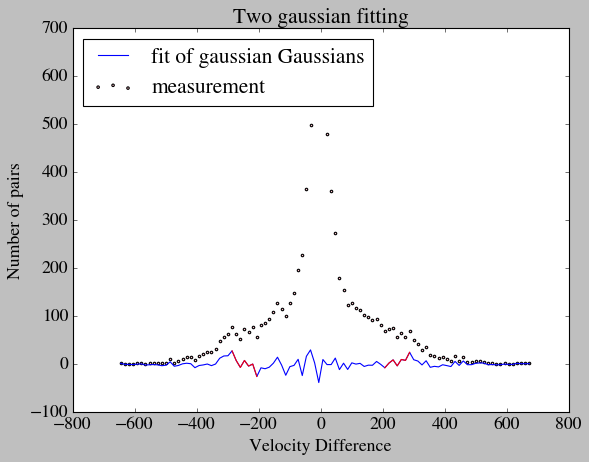

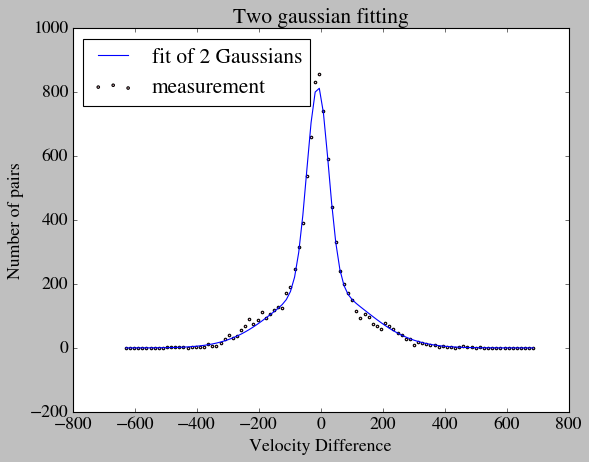

1 9 30 39


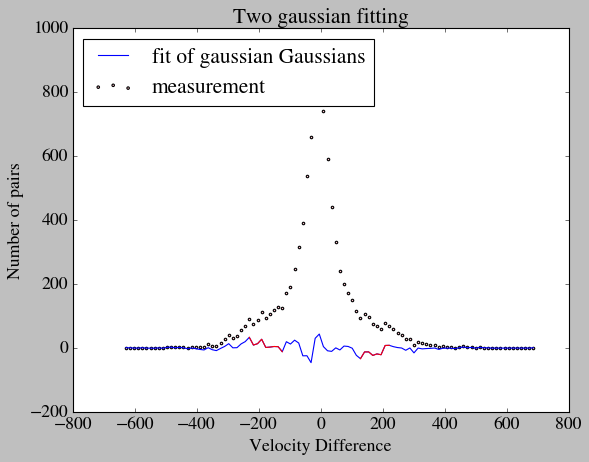

In [23]:
lowb,lowb2,highb,highb2 = gaussian_likelihood(4)

In [24]:
lowb,lowb2,highb,highb2

([-340.79654670276096,
  -323.51474584017046,
  -285.34138672689454,
  -230.1161251953307],
 [-223.43793992295616,
  -120.75962774625577,
  -205.43019427352067,
  -123.88767588874947],
 [145.40339567071624, 183.3730493946165, 207.44430006891116, 128.404891214381],
 [363.35509397606813,
  267.85434860041426,
  287.3554925222851,
  221.35478435763957])

In [26]:
def load_index(vel_diff,indexf,lowv,highv,lowv2,highv2):
    indexstot = []
    narrowtotal = []
    overlaptot = []
    indexoutot = [ ]
  
    print(lowv,highv,lowv2,highv2)
    
   
    
    
    

    #indexcut = indexf[(((vel_diff > lowv) & (vel_diff < highv)) or ((vel_diff > lowv2) & (vel_diff < highv2)))] 
    indexcut = np.append(indexf[((vel_diff  > lowv) & (vel_diff < highv))], indexf[((vel_diff > lowv2) & (vel_diff < highv2))]) 
    
    indexout1 = np.append(indexf[(vel_diff < lowv)],indexf[(vel_diff > highv) & (vel_diff < lowv2)])
    
    indexout = np.append(indexout1,indexf[(vel_diff > highv2)])
    
    
    print (indexout)
    indexoutt = []
    indexs = []
    for item in indexout:
        indexoutt.append(int(item[:item.find('-')]))
        indexoutt.append(int(item[item.find('-')+1:]))

    indexoutot.append(indexoutt)
    for item in indexcut:
        indexs.append(int(item[:item.find('-')]))
        indexs.append(int(item[item.find('-')+1:]))
        
        
            
    overlap = []

    for item1 in np.unique(indexoutt):
        for item2 in np.unique(indexs):
            if item1 == item2:
                overlap.append(item2)
    totaln = []
    uniqueid =  []



    for ii in range(0,len(indexs)):
        n = 0 
        for item1 in overlap:
            if indexs[ii] == item1:
                n=n+1
      
      

        if n ==0:
        
            
            uniqueid.append(indexs[ii])
        totaln.append(n)
    indexstot.append(np.ravel(indexs))
    overlaptot.append(np.ravel(indexs)[np.isin(np.ravel(indexs),overlap)])
    narrowtotal.append(np.ravel(uniqueid))
    
    return indexoutot,indexstot,overlaptot,narrowtotal

In [24]:
indexf[2][2]

array(['0-1600', '0-1619', '0-1720', ..., '22341-22393', '22355-22401',
       '22398-22401'], dtype='<U11')

In [27]:
indexoutot,indexstot,overlaptot,narrowtotal = [],[],[],[]
for ii in range(0,4):

    indexoutoti,indexstoti,overlaptoti,narrowtotali = load_index(test1f[2][ii],indexf[2][ii],lowb[ii],lowb2[ii],highb[ii],highb2[ii])
    indexoutot.append(indexoutoti)
    indexstot.append(indexstoti)
    overlaptot.append(overlaptoti)
    narrowtotal.append(narrowtotali)


-340.79654670276096 -223.43793992295616 145.40339567071624 363.35509397606813
['0-52' '0-4016' '1-402' ... '19878-19889' '20243-20449' '20320-20504']
-323.51474584017046 -120.75962774625577 183.3730493946165 267.85434860041426
['10-1794' '33-2087' '34-2110' ... '20206-20353' '20282-20400'
 '20351-20477']
-285.34138672689454 -205.43019427352067 207.44430006891116 287.3554925222851
['57-2632' '57-2956' '130-2591' ... '19620-20455' '19869-20133'
 '20174-20372']
-230.1161251953307 -123.88767588874947 128.404891214381 221.35478435763957
['118-1922' '120-291' '126-2939' ... '19623-20407' '20115-20387'
 '20115-20407']


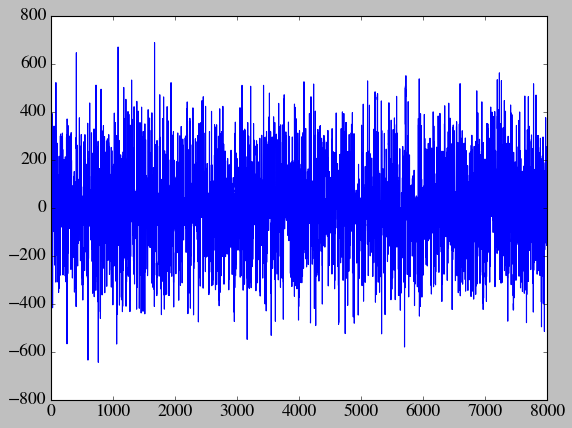

In [28]:
plt.plot(test1f[2][2])
plt.show()

In [390]:
#plotting narrow peak star satellite properties
def sate_narrow_plot(rlim,inputid,df3,totalstarid,totaldata,satlow,sathigh,radius,interval):
    data2=ebf.read('/Users/Jenny/thesis_idea_test/halo/galaxia/bj/'+'satprop.ebf') #reads in ebf file for galaxia output
    df=pd.DataFrame() #creates empty pandas DataFrame
    fig, ax = plt.subplots(2, 2, figsize=(20, 12), gridspec_kw={'wspace': 0.15, 'hspace': 0.2}, sharex=True, sharey=True)

    fig.subplots_adjust(left=0.05, bottom=0.05, right=0.9, top=0.9)
    k = 0
    
    degrees = [(0, 0), (1, 0), (2, 0), (3, 0), (0, 1), (1, 1), (2, 1), (0, 2), (1, 2), (0, 3)]
    for index in range(ax.shape[0]):
        for jndex in range(ax.shape[1]):
            
            staridf = df3['starid'][np.isin(df3['index'],np.ravel(inputid[k]))]
            

            satidunqiue = testd['satid'][np.isin(totalstarid,staridf)]

            satidcut = np.isin(np.arange(satlow,sathigh),np.unique(satidunqiue))
            
            print (satidunqiue)
            #print (staridf,satidunqiue)
            ax[index][jndex].scatter(data2['jsat'][satlow:sathigh][satidcut],data2['tsat'][satlow:sathigh][satidcut],marker='o', c='b',s=data2['msat'][satlow:sathigh][satidcut]/10E8, label=str(int(radius[k])) +'-'+ str(int(radius[k]+8))+'kpc')
            #ax[index][jndex].scatter(df3['x'],df3['y'],df3['z'],c='b',marker='o',s=1,alpha= 0.3,label = 'All stars in the sample')
            #ax[index][jndex].scatter(df4['x'],df4['y'],df4['z'],c='red',marker='^',label = 'Stars from |Vdiff| < 80 km/s in the sample ')
            

            ax[index][jndex].set_xlabel('Circularity')
            ax[index][jndex].set_ylabel('Accrected Time (Gyr)')
            ax[index][jndex].legend( prop={'size': 16})
        
            
            
            k = k + 1
#plt.savefig('halo17_space_2_unbound.png')             
    fig, ax = plt.subplots(2, 2, figsize=(20, 12), gridspec_kw={'wspace': 0.15, 'hspace': 0.2}, sharex=True, sharey=True)

    fig.subplots_adjust(left=0.05, bottom=0.05, right=0.9, top=0.9)
    k = 0
    
    degrees = [(0, 0), (1, 0), (2, 0), (3, 0), (0, 1), (1, 1), (2, 1), (0, 2), (1, 2), (0, 3)]
    for index in range(ax.shape[0]):
        for jndex in range(ax.shape[1]):
            
            staridf = df3['starid'][np.isin(df3['index'],df3['index'][(rlim[k] < df3['r']) & (df3['r']<rlim[k]+interval )])]

            satidunqiue = testd['satid'][np.isin(totalstarid,staridf)]

            satidcut = np.isin(np.arange(satlow,sathigh),np.unique(satidunqiue))
            
            #print (staridf,satidunqiue)
            ax[index][jndex].scatter(data2['jsat'][satlow:sathigh][satidcut],data2['tsat'][satlow:sathigh][satidcut],marker='o', c='b',s=data2['msat'][satlow:sathigh][satidcut]/10E8, label=str(int(radius[k])) +'-'+ str(int(radius[k]+8))+'kpc')
            #ax[index][jndex].scatter(df3['x'],df3['y'],df3['z'],c='b',marker='o',s=1,alpha= 0.3,label = 'All stars in the sample')
            #ax[index][jndex].scatter(df4['x'],df4['y'],df4['z'],c='red',marker='^',label = 'Stars from |Vdiff| < 80 km/s in the sample ')
            

            ax[index][jndex].set_xlabel('Circularity')
            ax[index][jndex].set_ylabel('Accrection Time (Gyr)')
            ax[index][jndex].legend( prop={'size': 16})
        
            
            
            k = k + 1
    plt.show()
    
        
        
             
        
        
        
            
            
        
        
        
        
        
    
    
        
   
        
        

In [ ]:
#plotting narrow peak star satellite properties
def sate_narrow_plot_2(rlim,inputid,df3,totalstarid,totaldata,satlow,sathigh,radius,interval):
    data2=ebf.read('/Users/Jenny/thesis_idea_test/halo/galaxia/bj/'+'satprop.ebf') #reads in ebf file for galaxia output
    df=pd.DataFrame() #creates empty pandas DataFrame
    fig, ax = plt.subplots(2, 3, figsize=(20, 12), gridspec_kw={'wspace': 0.15, 'hspace': 0.2}, sharex=True, sharey=True)

    fig.subplots_adjust(left=0.05, bottom=0.05, right=0.9, top=0.9)
    k = 0
    
    degrees = [(0, 0), (1, 0), (2, 0), (3, 0), (0, 1), (1, 1), (2, 1), (0, 2), (1, 2), (0, 3)]
    for index in range(ax.shape[0]):
        for jndex in range(ax.shape[1]):
            satmass = [] 
            satmass2 = []
            staridf = df3['starid'][np.isin(df3['index'],np.ravel(inputid[k]))]
            satidunqiue = testd['satid'][np.isin(totalstarid,staridf)]
            sattot = np.arange(satlow,sathigh)
            
            staridf2 = df3['starid'][np.isin(df3['index'],df3['index'][(rlim[k] < df3['r']) & (df3['r']<rlim[k]+interval )])]

            satidunqiue2 = testd['satid'][np.isin(totalstarid,staridf2)]

            satidcut2 = np.isin(np.arange(satlow,sathigh),np.unique(satidunqiue2))
            print (len(data2['msat'][satlow:sathigh][satidcut2]))
            for kk in range(0,len(sattot)):
                satmass.append(data2['msat'][satlow:sathigh][kk]*len(satidunqiue[satidunqiue==sattot[kk]]))
                satmass2.append(data2['msat'][satlow:sathigh][kk]*len(satidunqiue2[satidunqiue2==sattot[kk]]))
                           
                                           

                     #satidunqiue = testd['satid'][np.isin(totalstarid,staridf)]

            satidcut = np.isin(np.arange(satlow,sathigh),satidunqiue)
            #print (len(np.ravel(np.nonzero(satmass))))
            
            #print (np.ravel(satmass)/10**12-np.ravel(satmass2)/10**12)
            ax[index][jndex].scatter(data2['jsat'][satlow:sathigh],data2['tsat'][satlow:sathigh],marker='o', c='b',s=(np.absolute(np.ravel(satmass)-np.ravel(satmass2)))/10**11, label=str(int(radius[k])) +'-'+ str(int(radius[k]+8))+'kpc')
            #ax[index][jndex].scatter(df3['x'],df3['y'],df3['z'],c='b',marker='o',s=1,alpha= 0.3,label = 'All stars in the sample')
            #ax[index][jndex].scatter(df4['x'],df4['y'],df4['z'],c='red',marker='^',label = 'Stars from |Vdiff| < 80 km/s in the sample ')
            

            ax[index][jndex].set_xlabel('Circularity')
            ax[index][jndex].set_ylabel('Accrected Time (Gyr)')
            ax[index][jndex].legend( prop={'size': 16})
        
            
            
            k = k + 1
    #plt.show()
    fig, ax = plt.subplots(2, 3, figsize=(20, 12), gridspec_kw={'wspace': 0.15, 'hspace': 0.2}, sharex=True, sharey=True)

    fig.subplots_adjust(left=0.05, bottom=0.05, right=0.9, top=0.9)
    j=0
    for index in range(ax.shape[0]):
        for jndex in range(ax.shape[1]):
            satmass = [] 
            satmass2 = []
            staridf = df3['starid'][np.isin(df3['index'],np.ravel(inputid[j]))]
            satidunqiue = testd['satid'][np.isin(totalstarid,staridf)]
            sattot = np.arange(satlow,sathigh)
            
            staridf2 = df3['starid'][np.isin(df3['index'],df3['index'][(rlim[j] < df3['r']) & (df3['r']<rlim[j]+interval )])]

            satidunqiue2 = list(set(testd['satid'][np.isin(totalstarid,staridf2)])-set(testd['satid'][np.isin(totalstarid,staridf)]))
            satidunqiue3 = testd['satid'][np.isin(totalstarid,staridf2)][np.isin(testd['satid'][np.isin(totalstarid,staridf2)],satidunqiue2)]
            #satidcut2 = testd['satid'][np.isin(totalstarid,staridf2)][np.isin(testd['satid'][np.isin(totalstarid,staridf2)],np.unique(satidunqiue2))]
            #print (len(satidunqiue),len(satidunqiue3))
            for kk in range(0,len(sattot)):
                satmass.append(data2['msat'][satlow:sathigh][kk]*len(satidunqiue[satidunqiue==sattot[kk]]))
                satmass2.append(data2['msat'][satlow:sathigh][kk]*len(np.array(satidunqiue3)[satidunqiue3==sattot[kk]]))
                           
                                           

                     #satidunqiue = testd['satid'][np.isin(totalstarid,staridf)]

            satidcut = np.isin(np.arange(satlow,sathigh),satidunqiue)
            #print (np.ravel(satmass2)-np.ravel(satmass))
            
        
            #ax[index][jndex].scatter(data2['tsat'][satlow:sathigh], np.ravel(satmass)/np.ravel(satmass2)*100000, label=str(int(radius[j])) +'-'+ str(int(radius[j]+8))+'kpc')
            #ax[index][jndex].scatter(df3['x'],df3['y'],df3['z'],c='b',marker='o',s=1,alpha= 0.3,label = 'All stars in the sample')
            #ax[index][jndex].scatter(df4['x'],df4['y'],df4['z'],c='red',marker='^',label = 'Stars from |Vdiff| < 80 km/s in the sample ')
            
            ax[index][jndex].scatter(data2['jsat'][satlow:sathigh],data2['tsat'][satlow:sathigh],marker='o', c='b',s=(np.absolute(np.ravel(satmass)-np.ravel(satmass2)))/10**11, label=str(int(radius[j])) +'-'+ str(int(radius[j]+8))+'kpc')
            ax[index][jndex].set_xlabel('Circularity')
            ax[index][jndex].set_ylabel('Accrected Time (Gyr)')
            ax[index][jndex].legend( prop={'size': 16})
        
            
            
            j = j + 1
    plt.show()
#plt.savefig('halo17_space_2_unbound.png')             
 

67
56
47
42
39
35


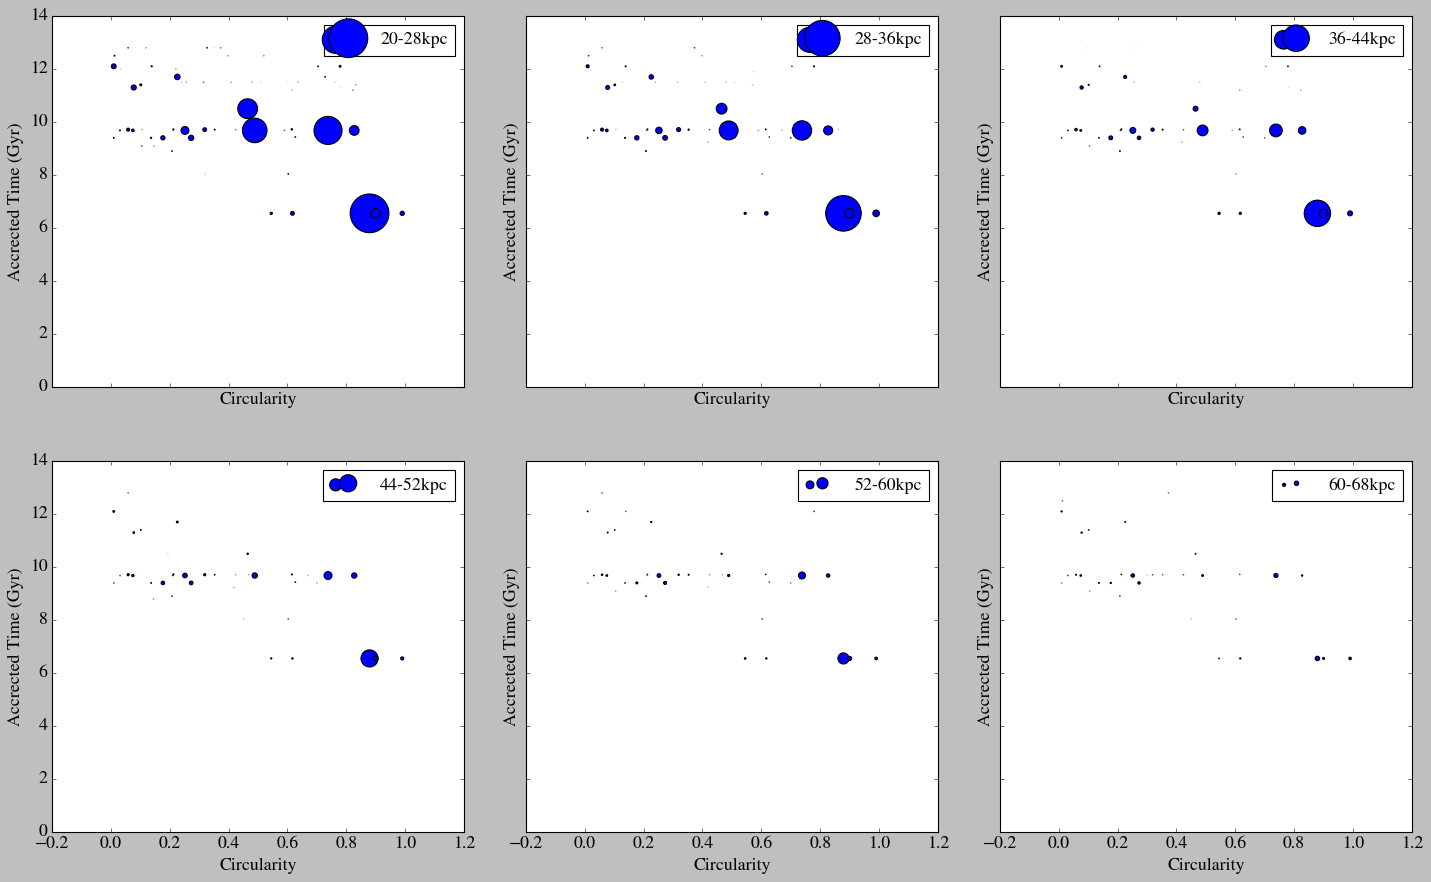

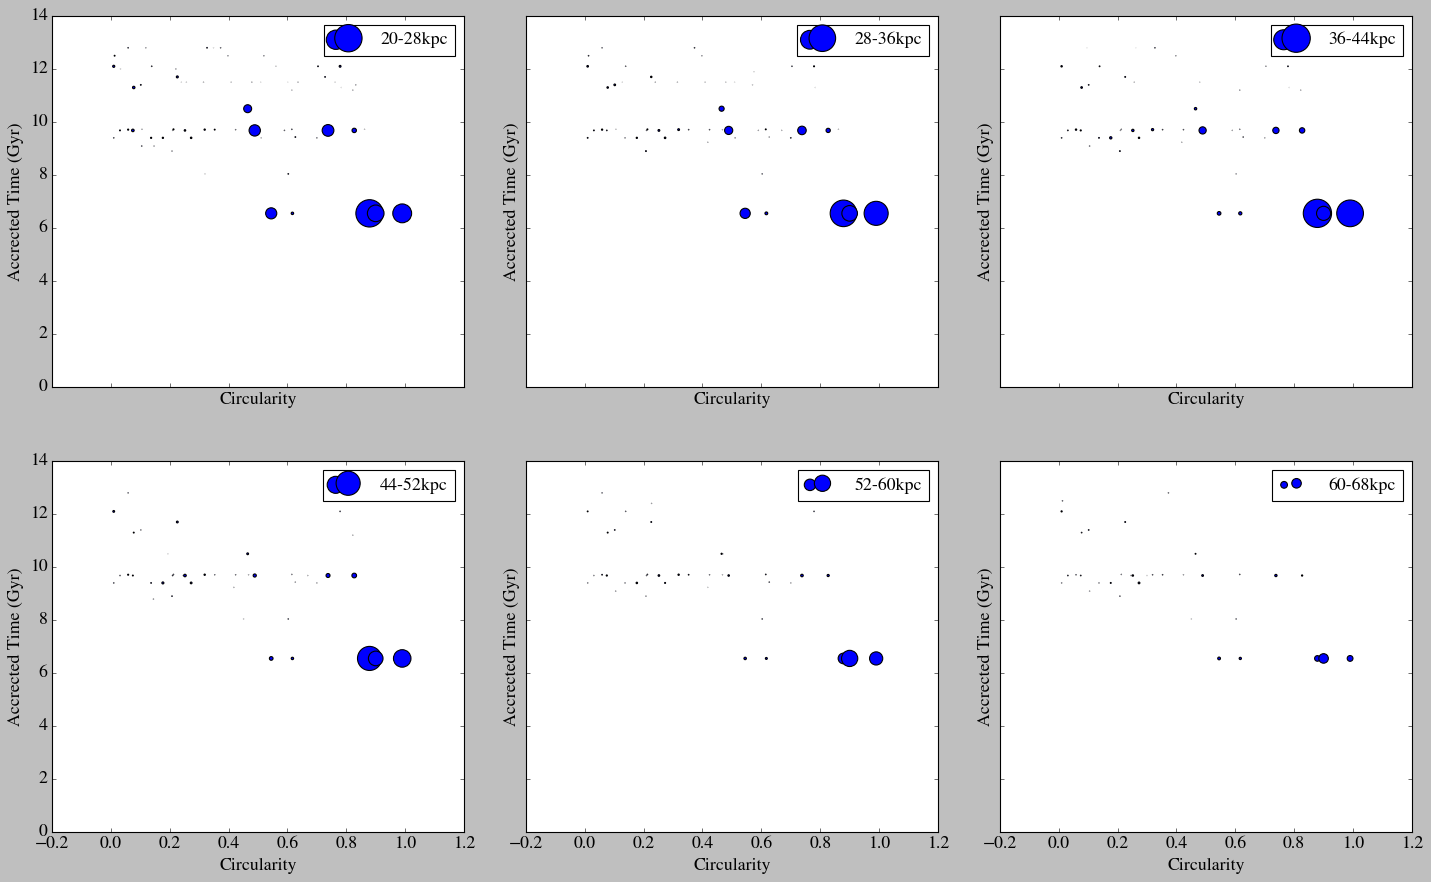

In [228]:
sate_narrow_plot_2(rlim,finalid,df3,groupidi,testd,1211,(1515-149),rlimf[2],8)

11       1254
14       1225
20       1239
31       1254
49       1223
56       1253
59       1257
63       1223
69       1253
94       1228
108      1248
111      1225
113      1224
120      1257
122      1223
139      1228
148      1254
152      1239
164      1253
184      1248
190      1223
197      1267
200      1267
205      1228
235      1228
238      1224
242      1223
244      1267
252      1224
254      1267
         ... 
59766    1223
59772    1253
59775    1253
59778    1225
59791    1274
59793    1223
59810    1247
59814    1253
59821    1254
59823    1225
59831    1253
59841    1223
59855    1223
59856    1223
59866    1223
59872    1228
59885    1267
59918    1223
59921    1224
59933    1248
59934    1223
59941    1269
59942    1248
59946    1254
59947    1225
59953    1299
59965    1228
59970    1239
59982    1249
59989    1223
Name: satid, Length: 7404, dtype: int32
0        1249
5        1223
6        1224
10       1225
19       1249
23       1225
45       1224
48      

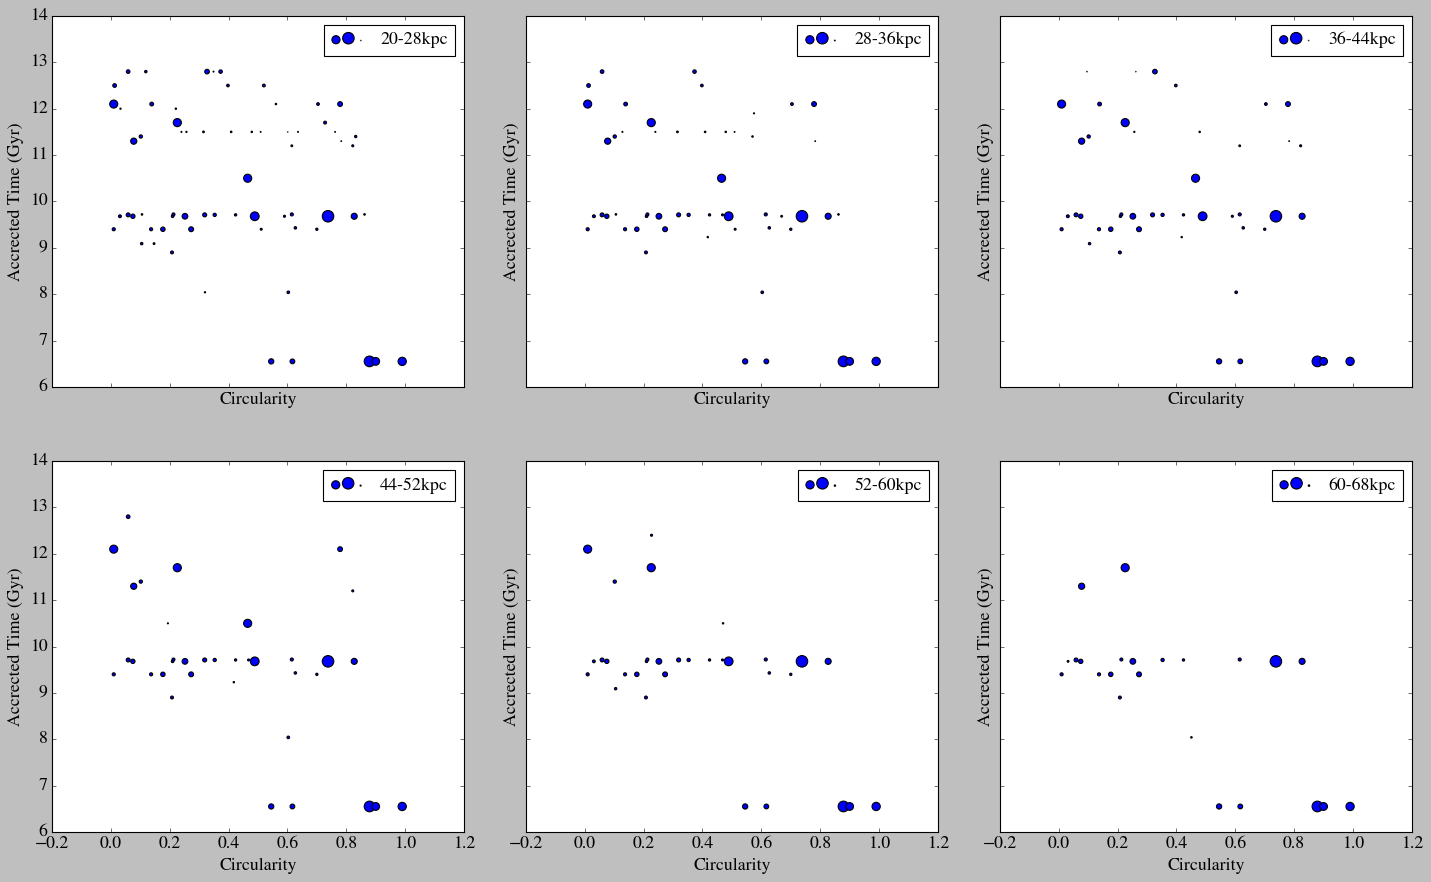

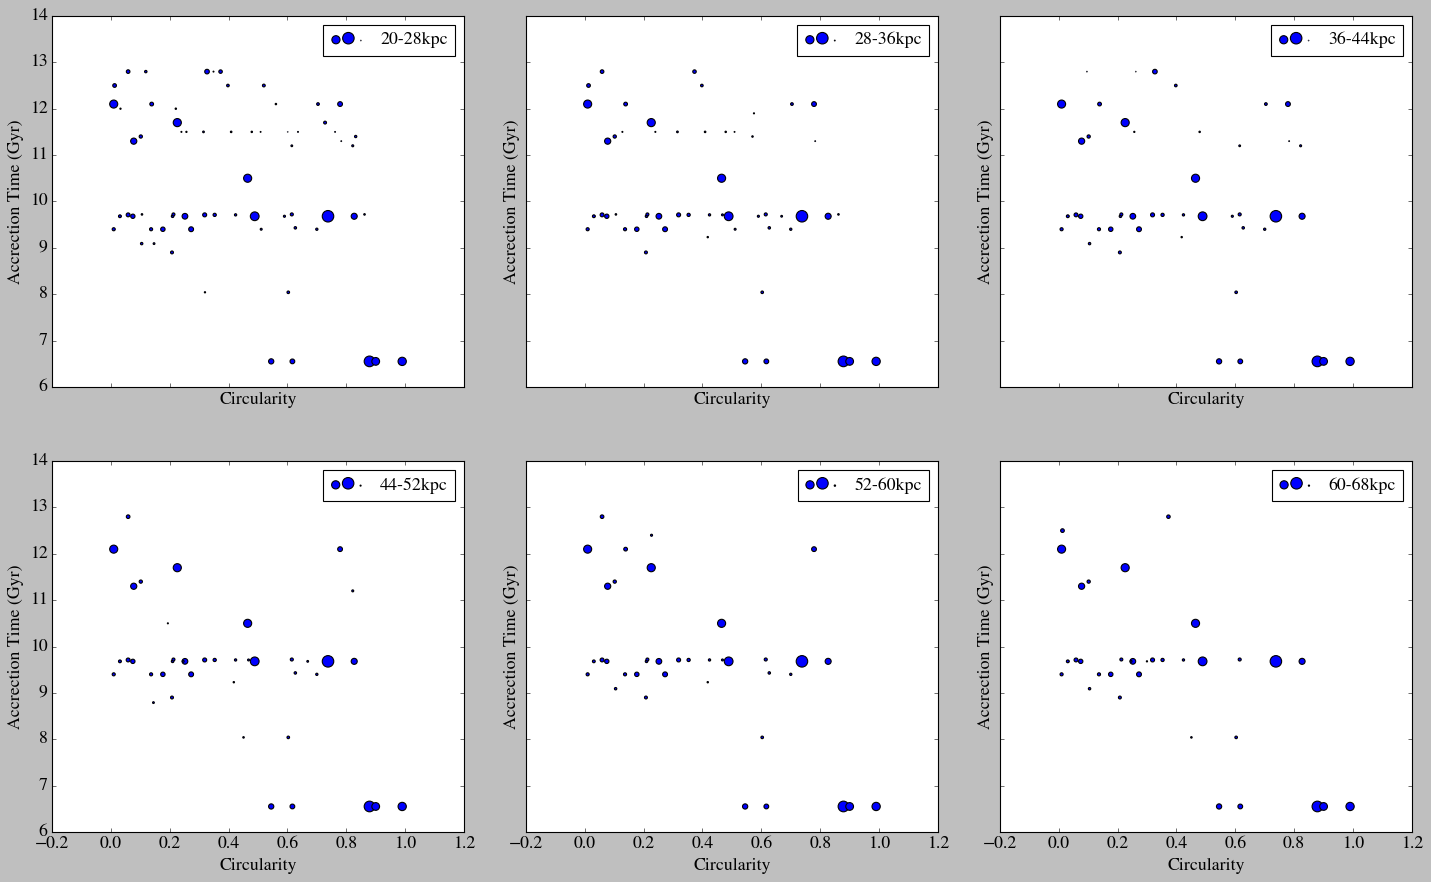

In [150]:
sate_narrow_plot(rlim,indexstot,df3,groupidi,testd,1211,(1515-149),rlimf[2],8)

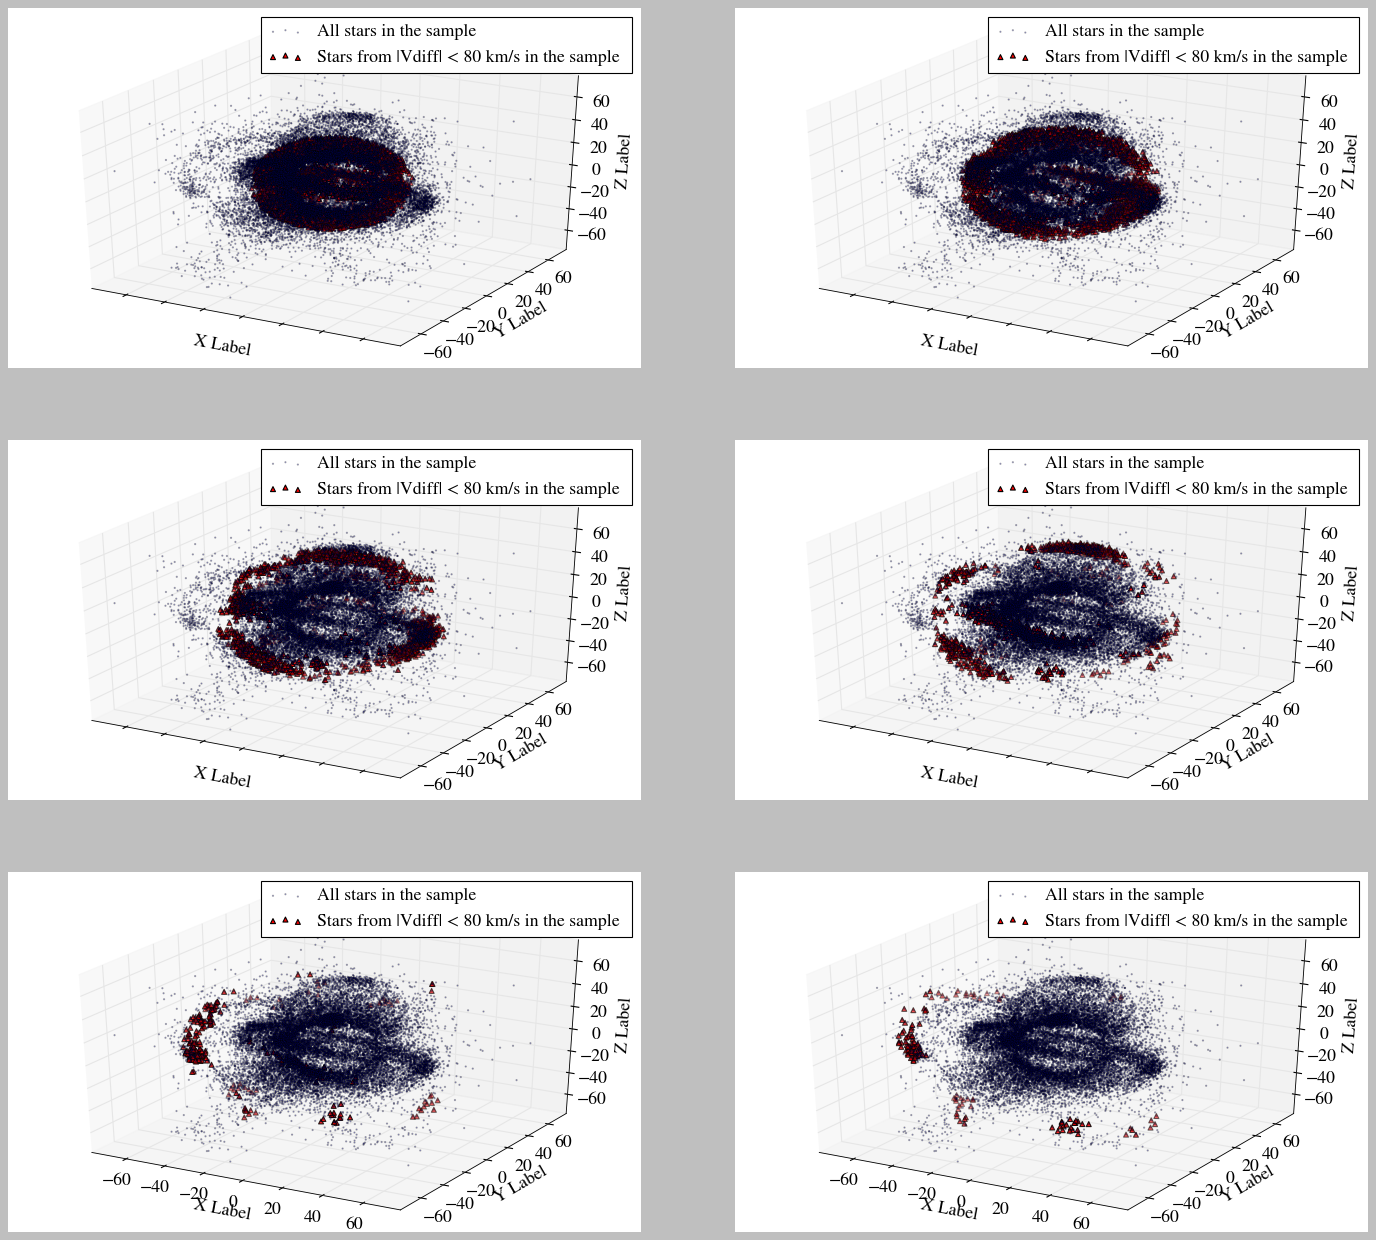

In [480]:
threed_narrow_plot(indexstot,df3)

In [44]:
#plotting narrow peak star position properties
def twod_narrow_plot(inputid,df3,radius):
    data2=ebf.read('/Users/Jenny/thesis_idea_test/halo/galaxia/bj/'+'satprop.ebf') #reads in ebf file for galaxia output
    df=pd.DataFrame() #creates empty pandas DataFrame
    
    fig, ax = plt.subplots(2, 2, figsize=(20, 18), gridspec_kw={'wspace': 0.15, 'hspace': 0.2}, sharex=True, sharey=False)
    #ax = fig.add_subplot(111,projection='3d')
    fig.subplots_adjust(left=0.05, bottom=0.05, right=0.9, top=0.9)
    k = 0
    
    degrees = [(0, 0), (1, 0), (2, 0), (3, 0), (0, 1), (1, 1), (2, 1), (0, 2), (1, 2), (0, 3)]
    for index in range(ax.shape[0]):
        for jndex in range(ax.shape[1]):
            
            dff = df3[df3['index'].isin(np.unique(inputid[k]))]
            ax[index][jndex].scatter(df3['y'],df3['z'],c='b',marker='o',s=1,alpha= 0.3,label = 'All stars in the sample')
            ax[index][jndex].scatter(dff['y'],dff['z'],c='red',marker='^',label = 'Stars from |Vdiff| < 80 km/s in the sample '+str(int(radius[k])) +'-'+ str(int(radius[k]+8))+' kpc')

            
            ax[index][jndex].set_xlabel('Y (Kpc)')
            ax[index][jndex].set_ylabel('Z (Kpc)')
            #ax[index][jndex].set_zlabel('Z Label')
            ax[index][jndex].set_ylim(-75,75)
            ax[index][jndex].set_xlim(-75,75)
            #ax[index][jndex].set_zlim(-75,75)
            ax[index][jndex].legend(loc=4,prop={'size': 13})

        
            
            
            k = k + 1
#plt.savefig('halo17_space_2_unbound.png')             
    plt.show()
    

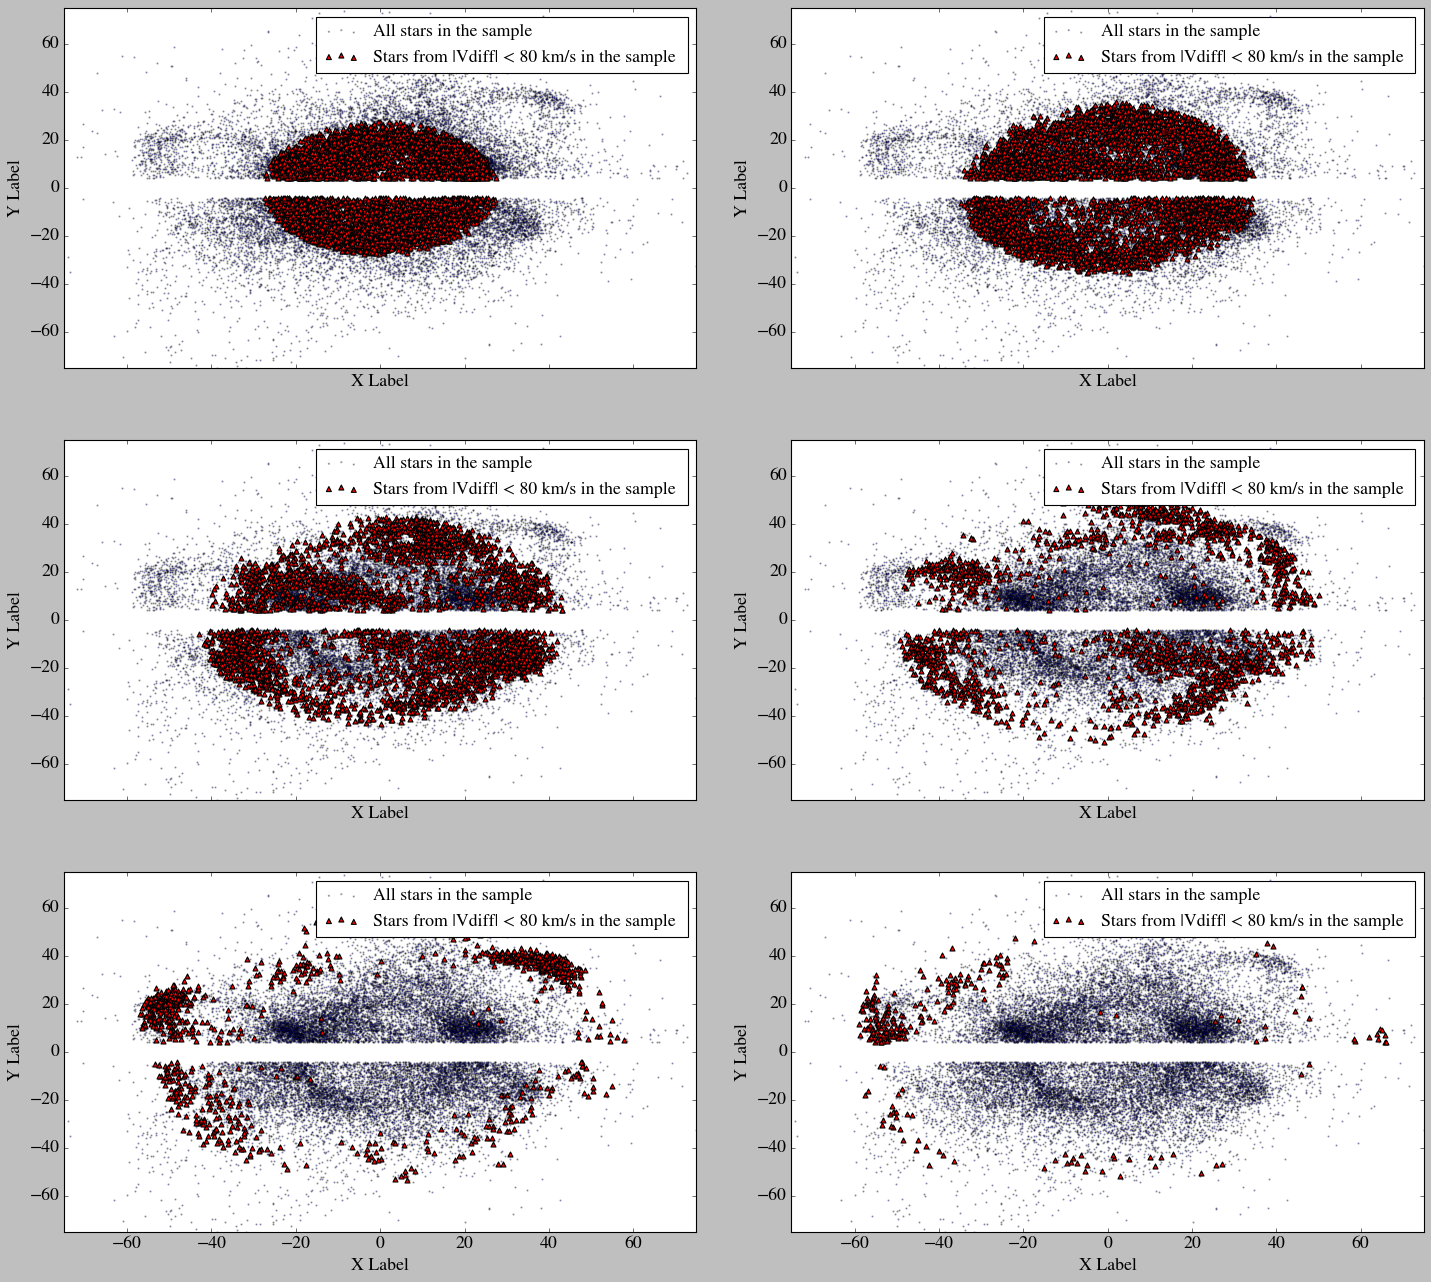

In [482]:
twod_narrow_plot(indexstot,df3)

In [394]:
#plotting narrow peak star histogram properties
def threed_narrow_hist(inputidal,inputidol,inputidna):
    data2=ebf.read('/Users/Jenny/thesis_idea_test/halo/galaxia/bj/'+'satprop.ebf') #reads in ebf file for galaxia output
    df=pd.DataFrame() #creates empty pandas DataFrame
    #subplot_args = {'projection':'3d'}
    fig, ax = plt.subplots(2, 2, figsize=(20, 12), gridspec_kw={'wspace': 0.15, 'hspace': 0.2}, sharex=True)
    #ax = fig.add_subplot(111,projection='3d')
    fig.subplots_adjust(left=0.05, bottom=0.05, right=0.9, top=0.9)
    k = 0
    
    degrees = [(0, 0), (1, 0), (2, 0), (3, 0), (0, 1), (1, 1), (2, 1), (0, 2), (1, 2), (0, 3)]
    for index in range(ax.shape[0]):
        for jndex in range(ax.shape[1]):
            
            
            ax[index][jndex].hist(np.ravel((inputidal[k])),bins=60,color='r',label = 'All ID found inside narrow peak')
            ax[index][jndex].hist(np.ravel(inputidal[k])[np.isin(np.ravel(inputidal[k]),inputidol[k])],bins=60,alpha=0.5,color='g',label = 'ID found outside narrow peak')
            ax[index][jndex].hist(np.ravel(inputidna[k]),bins=60,label = 'ID found only inside narrow peak',color = 'blue', alpha = 0.3)
            
            ax[index][jndex].set_xlabel('Star-ID')
            ax[index][jndex].set_ylabel('Number')
            

           
    
            ax[index][jndex].legend(prop={'size': 16})

        
            
            
            k = k + 1
#plt.savefig('halo17_space_2_unbound.png')             
    plt.show()
    

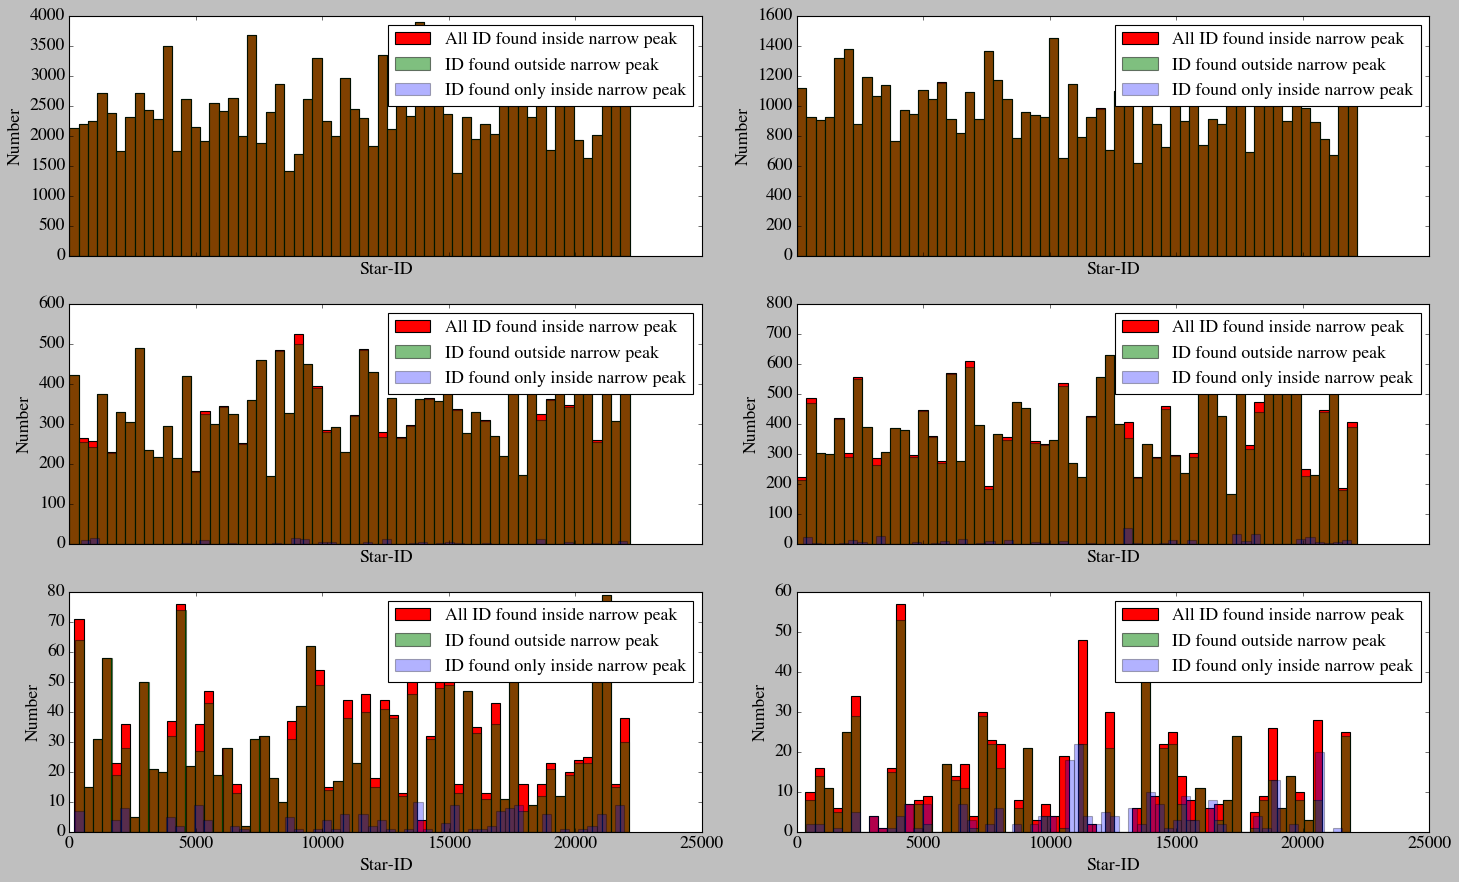

In [484]:
threed_narrow_hist(indexstot,overlaptot,narrowtotal)

In [514]:
a= [1,1,1,1,2,2,2,2,3,3,4,5,5]
from itertools import groupby
[len(list([])) for key, group in groupby(a)]

[1, 1, 1, 1, 1]

In [511]:
len(np.sort(indexoutot[0]))

761454

In [40]:
#plotting narrow peak star histogram properties
def threed_narrow_hist(inputidal,indexoutot):
    
    
    
    
    #idtotal = df3['index'][(rlim[k] < df3['r']) & (df3['r']<rlim[k]+interval )]
    #subplot_args = {'projection':'3d'}
    fig, ax = plt.subplots(2, 2, figsize=(20, 12), gridspec_kw={'wspace': 0.15, 'hspace': 0.2}, sharex=True)
    #ax = fig.add_subplot(111,projection='3d')
    fig.subplots_adjust(left=0.05, bottom=0.05, right=0.9, top=0.9)
    k = 0
    finalid = []
    degrees = [(0, 0), (1, 0), (2, 0), (3, 0), (0, 1), (1, 1), (2, 1), (0, 2), (1, 2), (0, 3)]
    for index in range(ax.shape[0]):
        for jndex in range(ax.shape[1]):
            
            outfre = []
            unique_id, counts_elements = np.unique(inputidal[k], return_counts=True)
            
            for item in unique_id:
                nn = 0
                for item2 in indexoutot[k]:
                    print (indexoutot[k])
                    if item == item2:
                        nn=nn+1
                outfre.append(nn)
            
            
            finalid.append(unique_id[(counts_elements-outfre) > 0])
            
    
    
            #outfre = [len(list(unique_id)) for key, group in groupby(indexoutot[k])]
            #print (len(unique_id), len(counts_elements),len(indexoutot[k]))
            
            #ax[index][jndex].plot(unique_id,counts_elements-outfre,c='r',label = 'Difference between two frequency')
            #ax[index][jndex].plot(unique_id,outfre)
            
            #ax[index][jndex].set_xlabel('Star-ID')
            #ax[index][jndex].set_ylabel('Count Number')
            

           
    
            #ax[index][jndex].legend(prop={'size': 16})

        
            
            
            k = k + 1
#plt.savefig('halo17_space_2_unbound.png')             
    plt.show()
    
    return finalid 
    

In [51]:
len(np.ravel(indexoutot)[1])

46720

In [60]:
len(np.ravel(indexstot)[0])

47712

In [59]:
 finalid  = threed_narrow_hist(np.ravel(indexstot)[:2],np.ravel(indexoutot)[:2])

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


KeyboardInterrupt: 

In [40]:
inputidal= np.ravel(indexstot)[3]


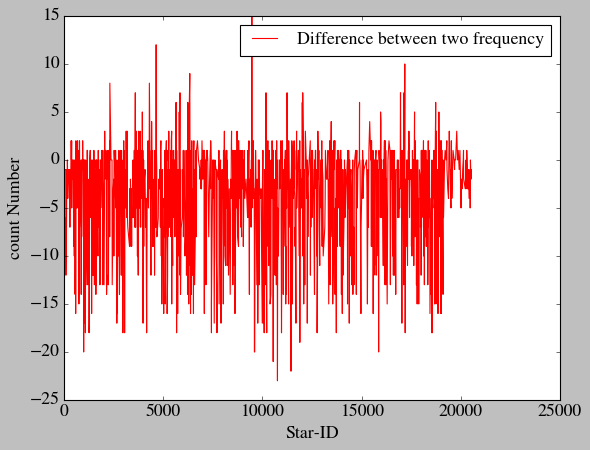

In [41]:
outfre = []
unique_id, counts_elements = np.unique(inputidal, return_counts=True)
finalid4 = []
for item in unique_id:
    nn = 0
    for item2 in np.ravel(indexoutot)[3]:
        #print (item2)
        if item == item2:
            nn=nn+1
    outfre.append(nn)
            
            
finalid4.append(unique_id[(counts_elements-outfre) > 0])
            
    
    
            #outfre = [len(list(unique_id)) for key, group in groupby(indexoutot[k])]
    #print (len(unique_id), len(counts_elements),len(indexoutot))
            
plt.plot(unique_id,counts_elements-outfre,c='r',label = 'Difference between two frequency')
            #ax[index][jndex].plot(unique_id,outfre)
            
plt.xlabel('Star-ID')
plt.ylabel('count Number')
            
         

           
    
plt.legend(prop={'size': 16})

        
            
            
      
#plt.savefig('halo17_space_2_unbound.png')             
plt.show()
    
 
    

In [42]:
finaid = [finalid[0],finalid2[0],finalid3[0],finalid4[0]]

In [100]:
len(finalid2[0])

655

In [392]:
sate_narrow_plot(rlim,indexstot,df3,groupidi,testd,1211,(1515-149),rlimf[2],8)

NameError: name 'groupidi' is not defined

In [86]:
finaid

array([    1,   198,   299,   325,   369,   676,  1804,  1922,  1962,
        2000,  2473,  2744,  2881,  2950,  3122,  3419,  3439,  3572,
        3597,  3750,  4234,  4294,  4424,  5303,  5361,  5553,  5758,
        6154,  6227,  6285,  6788,  7313,  7486,  7586,  7853,  7890,
        7913,  8528,  8599,  9018,  9180,  9352,  9437,  9456,  9693,
        9799,  9816, 10095, 10121, 10192, 10409, 10542, 11150, 11191,
       11288, 11342, 11383, 11547, 11631, 11890, 11934, 11988, 12090,
       12096,     1,   198,   299,   325,   369,   676,  1804,  1922,
        1962,  2000,  2473,  2744,  2881,  2950,  3122,  3419,  3439,
        3572,  3597,  3750,  4234,  4294,  4424,  5303,  5361,  5553,
        5758,  6154,  6227,  6285,  6788,  7313,  7486,  7586,  7853,
        7890,  7913,  8528,  8599,  9018,  9180,  9352,  9437,  9456,
        9693,  9799,  9816, 10095, 10121, 10192, 10409, 10542, 11150,
       11191, 11288, 11342, 11383, 11547, 11631, 11890, 11934, 11988,
       12090, 12096]

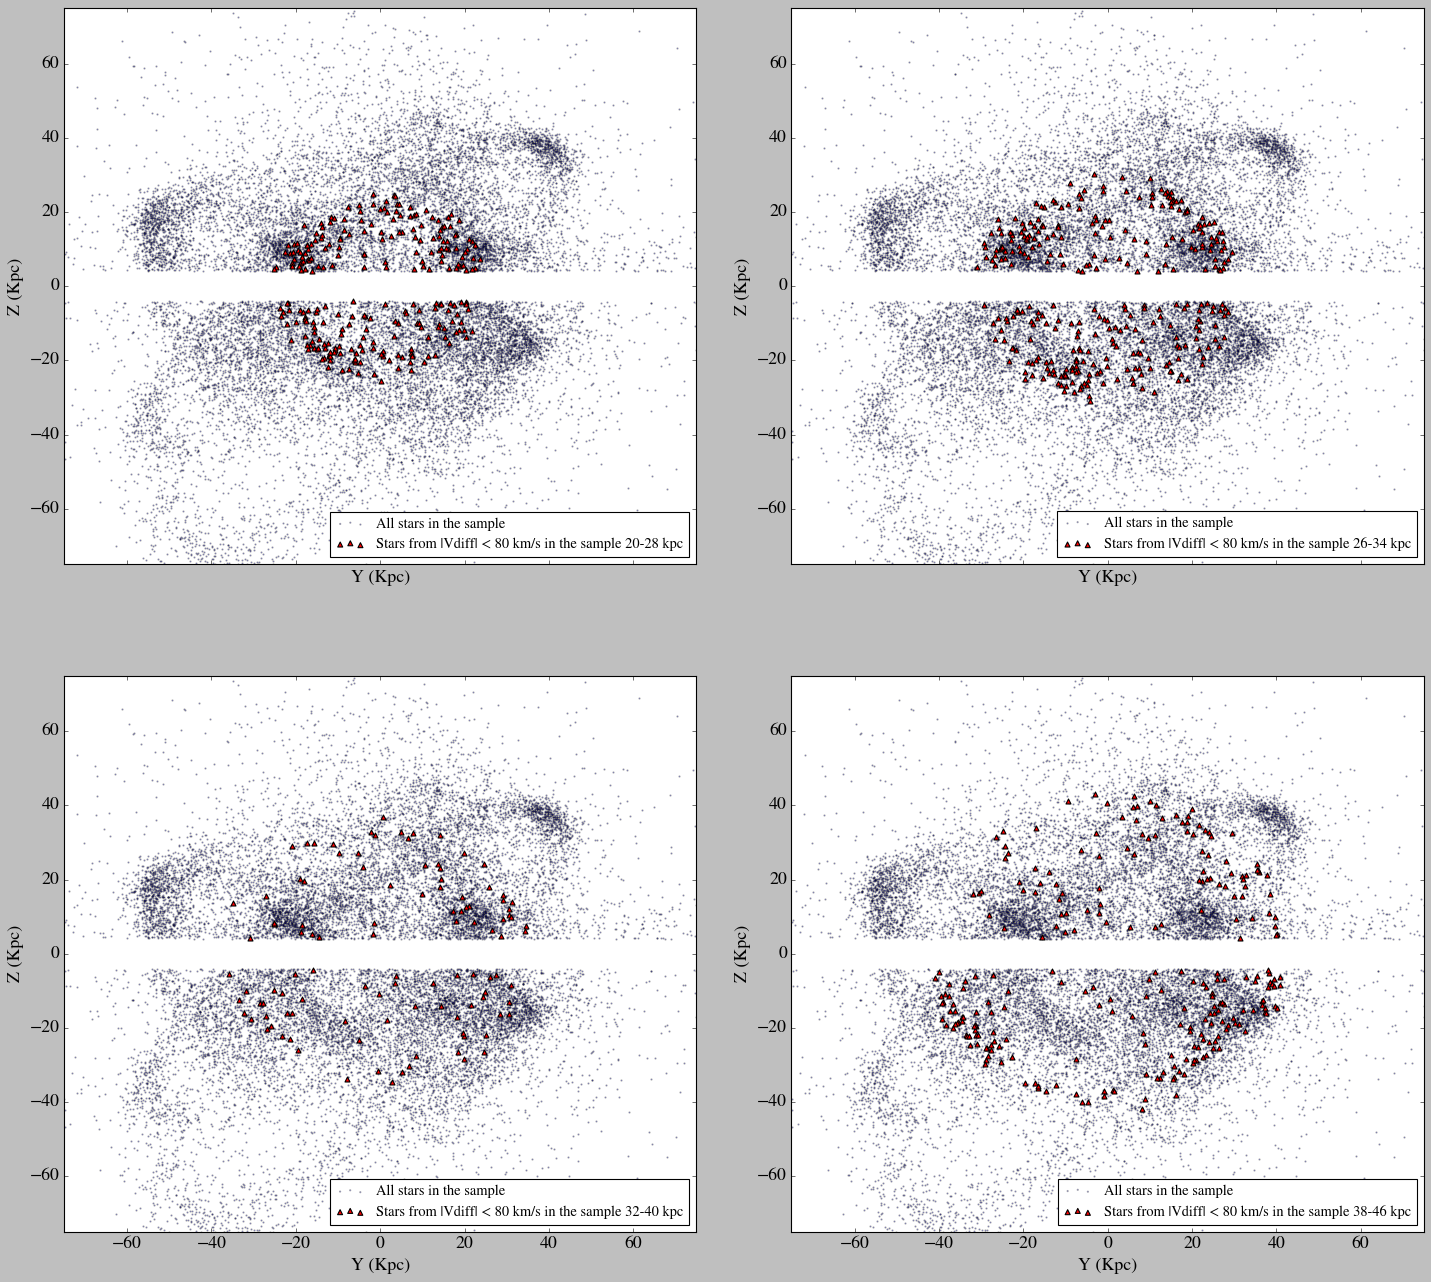

In [45]:
twod_narrow_plot(finaid,df3,rlim)

In [1]:
twod_narrow_plot(narrowtot,df3,rlim)

NameError: name 'twod_narrow_plot' is not defined

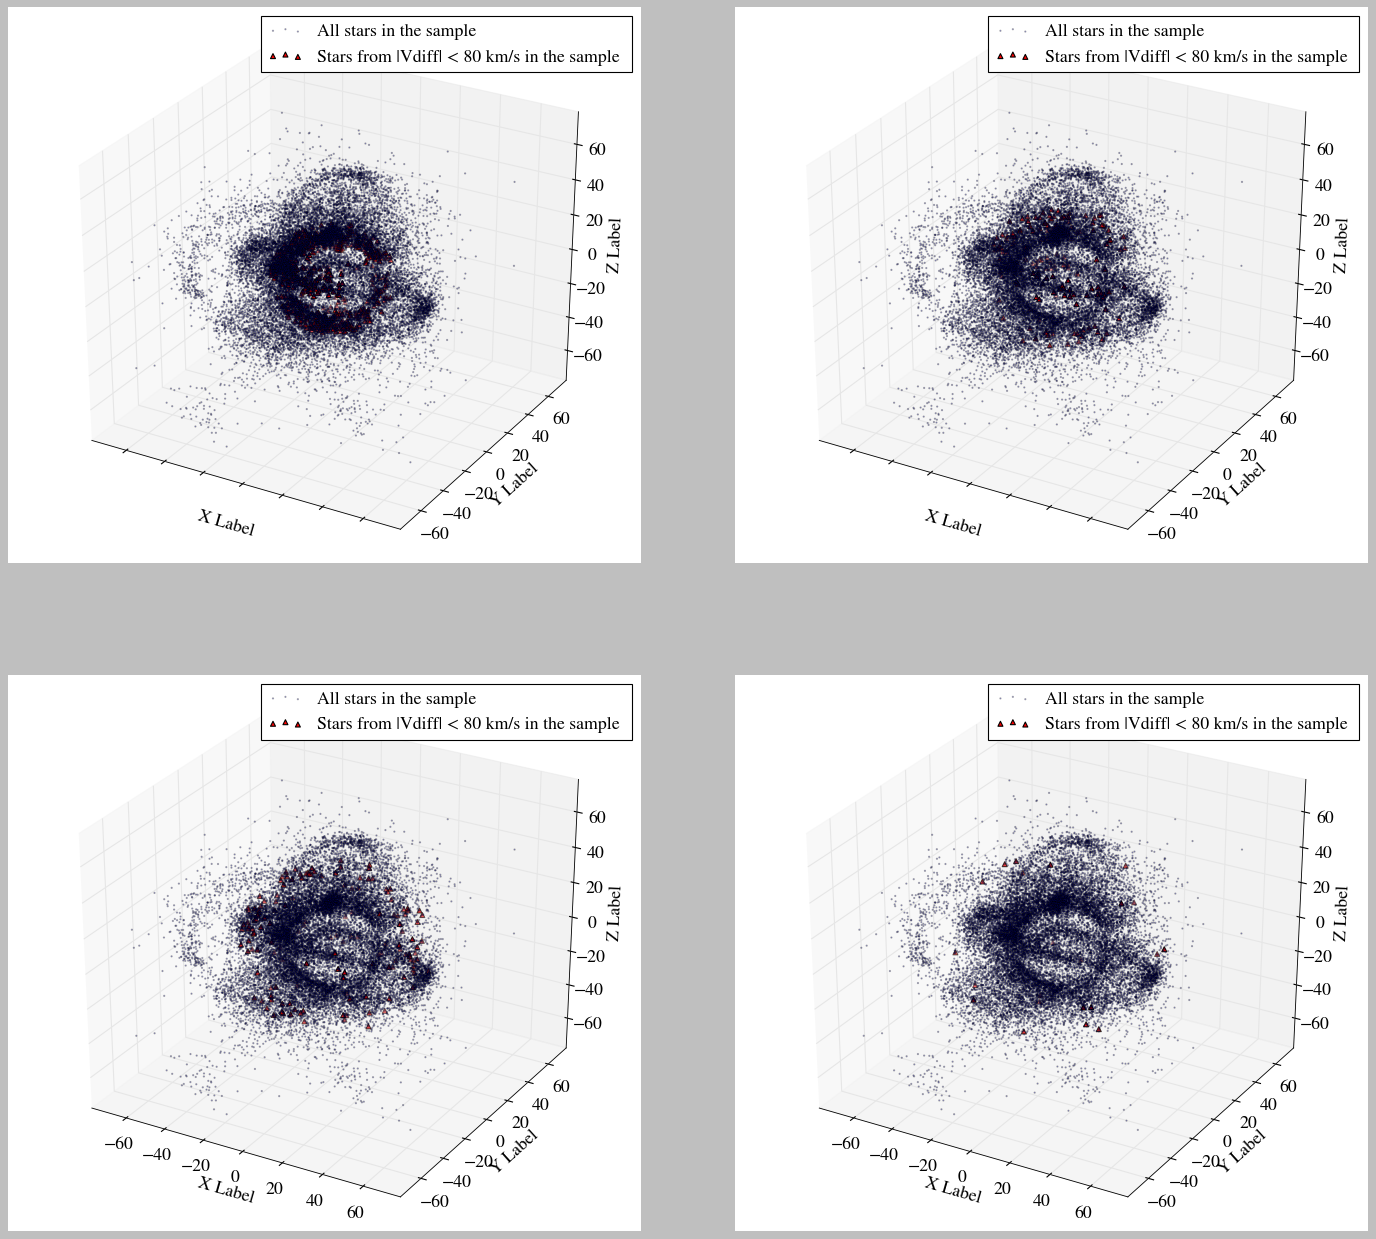

In [43]:
threed_narrow_plot(finaid,df3)

In [581]:
uniindex = list(set(df3['index'][ (60 < df3['r'] ) & (df3['r'] < 68 )])-set(finalid[5]))

In [582]:
len(uniindex)

205

# Stellar Mass of Satellites

In [28]:
len(data2['msat'])

1515

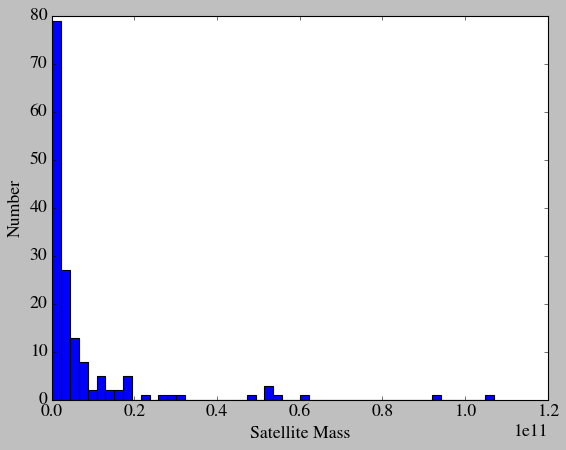

In [80]:
plt.hist(data2['msat'][1211:(1515-149)],bins=50)
plt.xlabel('Satellite Mass')
plt.ylabel('Number')
plt.show()

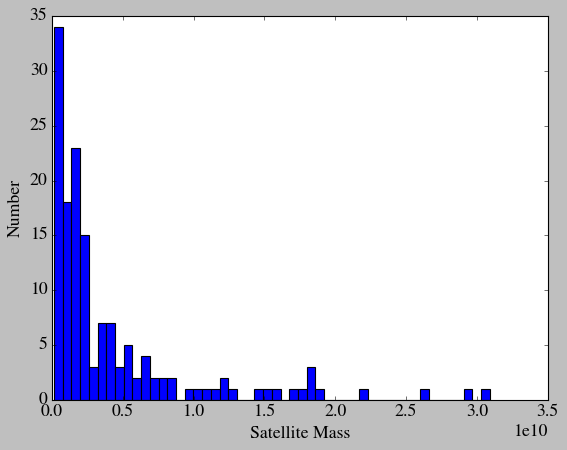

In [31]:
plt.hist(data2['msat'][1211:(1515-149)][data2['msat'][1211:(1515-149)] < 0.4e11],bins=50)
plt.xlabel('Satellite Mass')
plt.ylabel('Number')
plt.show()